# seg_lambda=0.3, alpha=0.5000
# use_eca=True, use_seg_guided=False

## 1. Paths & Training Hyperparameters

In [15]:
import os, sys, math, time, random, itertools
from typing import Tuple, List, Dict
import timm

IMG_ROOT = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images"
TRAIN_CSV = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv"
TEST_CSV  = r"C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv"
MASK_ROOT = IMG_ROOT.replace("png_images", "png_masks")  

OUT_DIR   = "./Baseline+ECA_Output"

IMG_SIZE  = 576  
EPOCHS    = 120       
BATCH     = 4        
LR        = 2e-4
SEED      = 42
VAL_RATIO = 0.20       
SAMPLER   = "off"  

print("IMG_ROOT:", IMG_ROOT)
print("TRAIN_CSV:", TRAIN_CSV)
print("TEST_CSV:", TEST_CSV)
print("OUT_DIR:", OUT_DIR)
print("EPOCHS/BATCH/LR:", EPOCHS, BATCH, LR)
print("VAL_RATIO/SAMPLER:", VAL_RATIO, SAMPLER)

IMG_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images
TRAIN_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_train_images.csv
TEST_CSV: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\stage_1_test_images.csv
OUT_DIR: ./Baseline+ECA_Output
EPOCHS/BATCH/LR: 120 4 0.0002
VAL_RATIO/SAMPLER: 0.2 off


## 2. Imports & Device

In [16]:
import numpy as np
import pandas as pd
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from torchvision.transforms import functional as TF
from torchvision.transforms import InterpolationMode
import torchvision

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             confusion_matrix, roc_curve, precision_recall_curve)

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({"figure.dpi": 110})

def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(SEED)
print(f"Using device: {device} | AMP: {'on' if device.type=='cuda' else 'off'}")

Using device: cuda | AMP: on


## 3. Read CSVs & Quick Preview

In [17]:
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

display(train_df.head(8))
display(test_df.head(8))

print("Train shape:", train_df.shape, "Columns:", list(train_df.columns))
print("Test  shape:", test_df.shape, "Columns:", list(test_df.columns))

print("Train label distribution:", train_df["has_pneumo"].value_counts().to_dict())
print("Test  label distribution:", test_df["has_pneumo"].value_counts().to_dict())

new_filename                                            ImageId  \
0  0_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.5597.151787518...   
1  1_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.12515.15178752...   
2  2_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4904.151787518...   
3  3_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.32579.15178751...   
4  4_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.1314.151787516...   
5  5_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.11364.15178752...   
6  6_train_0_.png  1.2.276.0.7230010.3.1.4.8323329.4541.151787518...   
7  7_train_1_.png  1.2.276.0.7230010.3.1.4.8323329.4440.151787518...   

   has_pneumo  
0           0  
1           0  
2           1  
3           1  
4           1  
5           0  
6           0  
7           1

new_filename                                            ImageId  \
0  0_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5797.151787519...   
1  1_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5798.151787519...   
2  2_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5799.151787519...   
3  3_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.580.1517875163...   
4  4_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5800.151787519...   
5  5_test_0_.png  1.2.276.0.7230010.3.1.4.8323329.5801.151787519...   
6  6_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5802.151787519...   
7  7_test_1_.png  1.2.276.0.7230010.3.1.4.8323329.5803.151787519...   

   has_pneumo  
0           1  
1           0  
2           0  
3           0  
4           0  
5           0  
6           1  
7           1

Train shape: (10675, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Test  shape: (1372, 3) Columns: ['new_filename', 'ImageId', 'has_pneumo']
Train label distribution: {0: 8296, 1: 2379}
Test  label distribution: {0: 1082, 1: 290}


## 4. Full-path Resolution & Dataset 

In [18]:
IMG_MEAN = 0.4843
IMG_STD  = 0.2486

def resolve_full_paths(df: pd.DataFrame, img_root: str) -> pd.DataFrame:
    df = df.copy()
    def _resolve(row):
        name = str(row["new_filename"])
        name_png = name if name.lower().endswith(".png") else f"{name}.png"
        p1 = os.path.join(img_root, name_png)
        if os.path.exists(p1):
            return p1
        # fallback: ImageId.png
        alt = os.path.join(img_root, f"{row['ImageId']}.png")
        return alt if os.path.exists(alt) else p1
    df["full_path"] = df.apply(_resolve, axis=1)
    return df

train_df = resolve_full_paths(train_df, IMG_ROOT)
test_df  = resolve_full_paths(test_df,  IMG_ROOT)

missing_train = (~train_df["full_path"].apply(os.path.exists)).sum()
missing_test  = (~test_df["full_path"].apply(os.path.exists)).sum()
print(f"Missing files — Train: {missing_train} | Test: {missing_test}")

class PandasImageDataset(Dataset):
    def __init__(self, df: pd.DataFrame, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
    def __len__(self): return len(self.df)
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["full_path"]).convert("L")
        if self.transform: img = self.transform(img)
        y = int(row["has_pneumo"])
        return img, y
    
class JointImageMaskTransform:
    def __init__(self, out_size=IMG_SIZE):
        self.out_size = out_size

    def __call__(self, img, mask):
        # Resize + RandomResizedCrop + RandomHorizontalFlip + ToTensor + Normalize
        resize_to = int(self.out_size * 1.1)
        img  = TF.resize(img,  (resize_to, resize_to), interpolation=InterpolationMode.BILINEAR)
        mask = TF.resize(mask, (resize_to, resize_to), interpolation=InterpolationMode.NEAREST)

        i, j, h, w = torchvision.transforms.RandomResizedCrop.get_params(
            img,
            scale=(0.8, 1.0),
            ratio=(0.9, 1.1)
        )
        img  = TF.resized_crop(img,  i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.BILINEAR)
        mask = TF.resized_crop(mask, i, j, h, w, (self.out_size, self.out_size),
                               interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            img  = TF.hflip(img)
            mask = TF.hflip(mask)

        if random.random() < 0.5:
            angle = random.uniform(-7, 7)
            img  = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR)
            mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST)

        if random.random() < 0.5:
            b_factor = 1.0 + random.uniform(-0.15, 0.15)
            c_factor = 1.0 + random.uniform(-0.15, 0.15)
            img = TF.adjust_brightness(img, b_factor)
            img = TF.adjust_contrast(img, c_factor)

        img  = TF.to_tensor(img)               # [1,H,W], [0,1]
        img  = TF.normalize(img, [IMG_MEAN], [IMG_STD])

        mask = TF.to_tensor(mask)              # [1,H,W], [0,1]
        mask = (mask > 0.5).float()            # Binarize

        return img, mask

class PandasImageMaskDataset(Dataset):
    def __init__(self, df: pd.DataFrame, mask_root: str, joint_transform: JointImageMaskTransform):
        self.df = df.reset_index(drop=True)
        self.mask_root = mask_root
        self.joint_transform = joint_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # Images come from full_path
        img_path = row["full_path"]
        img = Image.open(img_path).convert("L")

        # Masks come from mask_root + basename
        basename = os.path.basename(img_path)
        mask_path = os.path.join(self.mask_root, basename)

        if not os.path.exists(mask_path):
            raise FileNotFoundError(f"Mask not found for {img_path} -> {mask_path}")

        mask = Image.open(mask_path).convert("L")

        img, mask = self.joint_transform(img, mask)

        y = float(row["has_pneumo"])
        return img, y, mask

Missing files — Train: 0 | Test: 0


## 5. Data visulization definition

### 5.1 Class distribution

In [19]:
os.makedirs(OUT_DIR, exist_ok=True)
EDA_DIR = os.path.join(OUT_DIR, "eda"); os.makedirs(EDA_DIR, exist_ok=True)

def eda_class_distribution(df: pd.DataFrame, label_col: str, out_path: str, title: str):
    counts = df[label_col].value_counts().sort_index()
    plt.figure(figsize=(6,4))
    xs = [str(int(x)) for x in counts.index.tolist()]
    ys = counts.values.astype(int)
    plt.bar(xs, ys)
    for i, y in enumerate(ys):
        plt.text(i, y, str(y), ha="center", va="bottom", fontsize=9)
    plt.title(f"Class Distribution — {title}")
    plt.xlabel("Label"); plt.ylabel("Count")
    plt.tight_layout(); plt.savefig(out_path); plt.show()

def eda_missing_files(df: pd.DataFrame, out_txt: str, title: str):
    missing_mask = ~df["full_path"].apply(os.path.exists)
    total = len(df); missing = missing_mask.sum()
    with open(out_txt, "w", encoding="utf-8") as f:
        f.write(f"Total rows: {total}\nMissing files: {missing}\n")
        if missing:
            f.write("First 50 missing examples:\n")
            f.write("\n".join(df.loc[missing_mask, "full_path"].head(50).tolist()))
    print(f"[{title}] Missing: {missing}/{total} — saved to {out_txt}")

def eda_sample_grid(df: pd.DataFrame, out_path: str, title: str, n_per_class: int = 8, size: int = 128):
    labels = sorted(df["has_pneumo"].unique().tolist())
    panels = []
    for lab in labels:
        subset = df[df["has_pneumo"] == lab]
        sample = subset.sample(min(n_per_class, len(subset)), random_state=0)
        panels.append(sample)

    cols = n_per_class; rows = len(labels)
    plt.figure(figsize=(cols*2, rows*2))
    idx = 1
    for r, panel in enumerate(panels):
        for _, row in panel.iterrows():
            fp = row["full_path"]
            plt.subplot(rows, cols, idx)
            try:
                img = Image.open(fp).convert("L").resize((size,size))
                plt.imshow(img, cmap="gray"); plt.axis("off")
            except Exception:
                plt.text(0.5,0.5,"missing",ha="center",va="center"); plt.axis("off")
            idx += 1
    plt.suptitle(f"Sample Grid — {title}", y=0.98)
    plt.tight_layout(); plt.savefig(out_path); plt.show()

### 5.2 Sample visulization

In [20]:
from pathlib import Path

def eda_sample_grid(df, out_path, split_name, n_per_class=6, size=128):
    label_col = "has_pneumo"
    path_col = "full_path" if "full_path" in df.columns else "filepath"

    classes = sorted(df[label_col].dropna().unique().tolist())
    nrows, ncols = len(classes), n_per_class
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*2.2, nrows*2.4))
    if nrows == 1:
        axes = np.array([axes])

    for r, c in enumerate(classes):
        sub = df[df[label_col] == c]
        sampled = sub.sample(n=min(n_per_class, len(sub)), random_state=42) if len(sub) > 0 else sub
        sampled = sampled.reset_index(drop=True)

        for i in range(ncols):
            ax = axes[r, i]
            ax.set_axis_off()

            if i < len(sampled):
                row = sampled.iloc[i]
                img_path = str(Path(row[path_col]))
                try:
                    im = Image.open(img_path).convert("L")
                    if size:
                        im = im.resize((size, size))
                    ax.imshow(im, cmap="gray")
                except Exception:
                    ax.imshow(np.zeros((size, size)), cmap="gray")

                ax.text(0.5, -0.08, str(row[label_col]),
                        transform=ax.transAxes, ha="center", va="top", fontsize=9)
            else:
                ax.imshow(np.zeros((size, size)), cmap="gray")

    plt.subplots_adjust(hspace=0.6, wspace=0.05)
    plt.show()
    Path(os.path.dirname(out_path)).mkdir(parents=True, exist_ok=True)
    # fig.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close(fig)

## 6. Data split (8:1:1)

In [21]:

# Combine train + test for splitting
full_df = pd.concat([train_df, test_df], ignore_index=True)

print("Original full size:", len(full_df))
print("Label distribution (full):", full_df["has_pneumo"].value_counts().to_dict())

# 20% of the data for val + test
from sklearn.model_selection import train_test_split

train_tmp, temp_df = train_test_split(
    full_df,
    test_size=0.2,               
    stratify=full_df["has_pneumo"],
    random_state=SEED,
)

# 10% val, 10% test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,              
    stratify=temp_df["has_pneumo"],
    random_state=SEED,
)

tr_df = train_tmp

print("8:1:1 split sizes ->",
      "Train:", len(tr_df),
      "Val:",   len(val_df),
      "Test:",  len(test_df))

print("Train label dist:", tr_df["has_pneumo"].value_counts().to_dict())
print("Val   label dist:", val_df["has_pneumo"].value_counts().to_dict())
print("Test  label dist:", test_df["has_pneumo"].value_counts().to_dict())

# Oversampling minority class in training set
pos_df = tr_df[tr_df["has_pneumo"] == 1]
neg_df = tr_df[tr_df["has_pneumo"] == 0]

n_pos = len(pos_df)
n_neg = len(neg_df)
target_pos = n_neg               

factor    = target_pos // n_pos
remainder = target_pos % n_pos

pos_oversampled = pd.concat(
    [pos_df] * factor + [pos_df.sample(remainder, replace=True, random_state=SEED)],
    ignore_index=True
)

tr_df_bal = pd.concat([neg_df, pos_oversampled], ignore_index=True)
tr_df_bal = tr_df_bal.sample(frac=1.0, random_state=SEED).reset_index(drop=True)

print("After oversampling Train label dist:",
      tr_df_bal["has_pneumo"].value_counts().to_dict())

tr_df = tr_df_bal


Original full size: 12047
Label distribution (full): {0: 9378, 1: 2669}
8:1:1 split sizes -> Train: 9637 Val: 1205 Test: 1205
Train label dist: {0: 7502, 1: 2135}
Val   label dist: {0: 938, 1: 267}
Test  label dist: {0: 938, 1: 267}
After oversampling Train label dist: {0: 7502, 1: 7502}


## 7. Data augmentation

In [22]:
# Transforms
train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[IMG_MEAN], std=[IMG_STD]),
])

# Joint transforms for image + mask (training set)
joint_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

# Datasets
ds_train = PandasImageMaskDataset(tr_df, mask_root=MASK_ROOT, joint_transform=joint_train_tfms)
ds_val   = PandasImageDataset(val_df, transform=eval_tfms)
ds_test  = PandasImageDataset(test_df, transform=eval_tfms)

def make_weights_for_balancing(df: pd.DataFrame) -> np.ndarray:
    counts = df["has_pneumo"].value_counts().to_dict()
    return df["has_pneumo"].map(lambda y: 1.0 / counts[int(y)]).values.astype(np.float32)


if SAMPLER == "on":
    weights = make_weights_for_balancing(tr_df)
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    shuffle = False
else:
    sampler = None; shuffle = True

# DataLoaders
dl_train = DataLoader(ds_train, batch_size=BATCH, sampler=sampler, shuffle=shuffle,
                      num_workers=0, pin_memory=True)
dl_val   = DataLoader(ds_val, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)
dl_test  = DataLoader(ds_test, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

# Use eval dataset for train_eval
ds_train_eval = PandasImageDataset(tr_df, transform=eval_tfms)
dl_train_eval = DataLoader(
    ds_train_eval, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True
)


len(ds_train), len(ds_val), len(ds_test)

(15004, 1205, 1205)

## 8. Comparison of before & after Standardizatin

In [10]:
from torchvision import transforms
from torch.utils.data import DataLoader

raw_tf = transforms.ToTensor()

ds_train_raw = PandasImageDataset(tr_df,  transform=raw_tf)
ds_val_raw   = PandasImageDataset(val_df, transform=raw_tf)
ds_test_raw  = PandasImageDataset(test_df, transform=raw_tf)

dl_train_raw = DataLoader(ds_train_raw, batch_size=BATCH, shuffle=False,
                          num_workers=0, pin_memory=True)
dl_val_raw   = DataLoader(ds_val_raw,   batch_size=BATCH, shuffle=False,
                          num_workers=0, pin_memory=True)
dl_test_raw  = DataLoader(ds_test_raw,  batch_size=BATCH, shuffle=False,
                          num_workers=0, pin_memory=True)


### 8.1 Calculate mean & std from dataloader

In [11]:
import torch

def compute_mean_std_from_loader(dataloader, max_batches=None, name=""):
    sum_ = 0.0
    sum_sq = 0.0
    n_pixels = 0

    for i, batch in enumerate(dataloader):
        if isinstance(batch, (list, tuple)):
            imgs = batch[0]
        else:
            imgs = batch
        
        imgs = imgs.float()
        b, c, h, w = imgs.shape
        imgs = imgs.view(b, c, -1)   # [B, C, H*W]

        sum_    += imgs.sum(dim=[0, 2])          # [C]
        sum_sq  += (imgs ** 2).sum(dim=[0, 2])   # [C]
        n_pixels += b * h * w

        if (max_batches is not None) and (i + 1 >= max_batches):
            break

    mean = sum_ / n_pixels
    std  = torch.sqrt(sum_sq / n_pixels - mean ** 2)

    print(f"{name} mean:", mean)
    print(f"{name} std :", std)
    print("-" * 60)
    return mean, std

### 8.2 Standardization checking

In [12]:
print("========== BEFORE standardization (0-1, ToTensor only) ==========")
train_raw_mean, train_raw_std = compute_mean_std_from_loader(dl_train_raw, name="Train raw")
val_raw_mean,   val_raw_std   = compute_mean_std_from_loader(dl_val_raw,   name="Val raw")
test_raw_mean,  test_raw_std  = compute_mean_std_from_loader(dl_test_raw,  name="Test raw")

print("\n========== AFTER standardization (using current pipeline) ==========")
train_std_mean, train_std_std = compute_mean_std_from_loader(dl_train, name="Train standardized")
val_std_mean,   val_std_std   = compute_mean_std_from_loader(dl_val,   name="Val standardized")
test_std_mean,  test_std_std  = compute_mean_std_from_loader(dl_test,  name="Test standardized")


========== BEFORE standardization (0-1, ToTensor only) ==========
Train raw mean: tensor([0.4843])
Train raw std : tensor([0.2486])
------------------------------------------------------------
Val raw mean: tensor([0.4876])
Val raw std : tensor([0.2467])
------------------------------------------------------------
Test raw mean: tensor([0.4914])
Test raw std : tensor([0.2497])
------------------------------------------------------------

========== AFTER standardization (using current pipeline) ==========


KeyboardInterrupt: 

### 8.3 Data visualization after standardization

Train pixels (raw)  shape: (838860800,)
Train pixels (std)  shape: (265420800,)


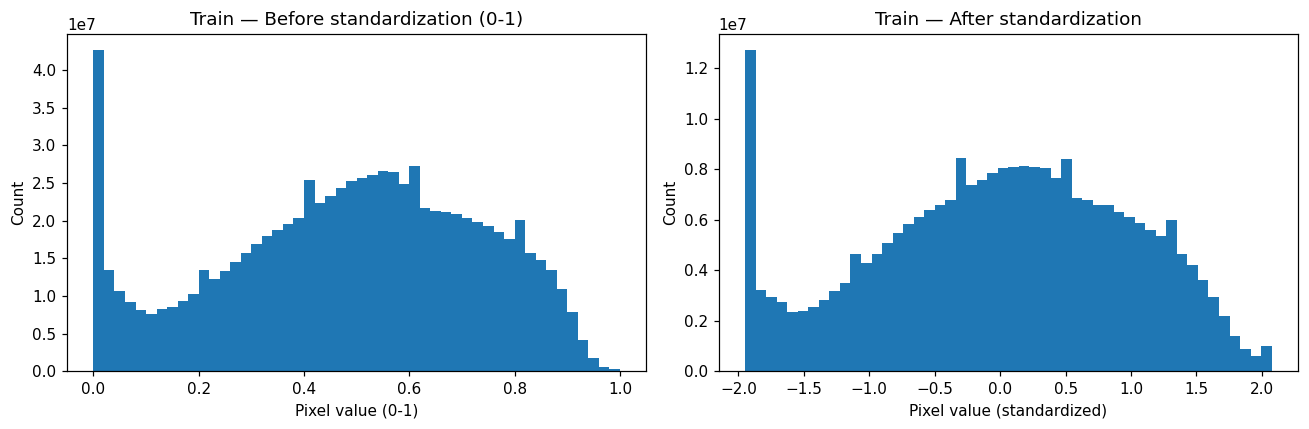

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def collect_pixels(dataloader, max_batches=200):
    all_pixels = []

    for i, batch in enumerate(dataloader):
        if isinstance(batch, (list, tuple)):
            imgs = batch[0]
        else:
            imgs = batch

        imgs = imgs.float().cpu()
        all_pixels.append(imgs.view(-1).numpy())

        if (max_batches is not None) and (i + 1 >= max_batches):
            break

    if len(all_pixels) == 0:
        return np.array([])
    return np.concatenate(all_pixels, axis=0)
train_pixels_raw  = collect_pixels(dl_train_raw, max_batches=200) 
train_pixels_std  = collect_pixels(dl_train,      max_batches=200) 

print("Train pixels (raw)  shape:", train_pixels_raw.shape)
print("Train pixels (std)  shape:", train_pixels_std.shape)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.title("Train — Before standardization (0-1)")
plt.hist(train_pixels_raw, bins=50)
plt.xlabel("Pixel value (0-1)")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
plt.title("Train — After standardization")
plt.hist(train_pixels_std, bins=50)
plt.xlabel("Pixel value (standardized)")
plt.ylabel("Count")

plt.tight_layout()
plt.show()


In [23]:
import os
import numpy as np
from PIL import Image

first_pos_idx = 1  

row = tr_df.iloc[first_pos_idx]
img_path = row["full_path"]
basename = os.path.basename(img_path)

print("img_path:", img_path)
print("basename:", basename)

print("MASK_ROOT:", MASK_ROOT)
mask_path = os.path.join(MASK_ROOT, basename)
print("mask_path:", mask_path, "exists:", os.path.exists(mask_path))

mask_raw = Image.open(mask_path).convert("L")
mask_np = np.array(mask_raw)

print("raw mask shape:", mask_np.shape)
print("raw mask min/max:", mask_np.min(), mask_np.max())
print("raw mask positive pixels (>0):", (mask_np > 0).sum())


img_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_images\10110_train_0_.png
basename: 10110_train_0_.png
MASK_ROOT: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks
mask_path: C:\Users\Steven\Desktop\Final Project\Datasets\Dataset_1\Chest X-Ray Images with Pneumothorax Masks\png_masks\10110_train_0_.png exists: True
raw mask shape: (1024, 1024)
raw mask min/max: 0 0
raw mask positive pixels (>0): 0


In [24]:
pos_indices = [i for i, v in enumerate(tr_df["has_pneumo"].values) if v == 1]
print("Positive sample number:", len(pos_indices))
first_pos_idx = pos_indices[0]

img, y, mask = ds_train[first_pos_idx]
print("index:", first_pos_idx)
print("label:", y)
print("mask shape:", mask.shape)
print("mask min/max:", mask.min().item(), mask.max().item())
print("mask positive pixels:", mask.sum().item())

Positive sample number: 7502
index: 5
label: 1.0
mask shape: torch.Size([1, 576, 576])
mask min/max: 0.0 1.0
mask positive pixels: 1227.0


## 9. ConvNeXt_V2

### 9.1 DropPath (Random Depth)

In [25]:
def drop_path(x, drop_prob: float = 0.0, training: bool = False):
    if drop_prob == 0.0 or not training:
        return x
    keep_prob = 1.0 - drop_prob
    # Only sample along batch dimension, broadcast others
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    random_tensor.floor_()  # binarize
    return x * random_tensor / keep_prob

class DropPath(nn.Module):
    def __init__(self, drop_prob: float = 0.0):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

### 9.2 GRN

In [26]:
class GRN(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))

    def forward(self, x):
        gx = torch.norm(x, p=2, dim=(1, 2), keepdim=True)                # [N,1,1,C]
        nx = gx / (gx.mean(dim=-1, keepdim=True) + 1e-6)                 # [N,1,1,C]
        return self.gamma * (x * nx) + self.beta + x                     # [N,H,W,C]

### 9.3 LayerNorm2d

In [27]:
class LayerNorm2d(nn.Module):
    def __init__(self, num_channels: int, eps: float = 1e-6):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(num_channels))
        self.bias = nn.Parameter(torch.zeros(num_channels))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(dim=1, keepdim=True)
        var = (x - mean).pow(2).mean(dim=1, keepdim=True)
        x = (x - mean) / torch.sqrt(var + self.eps)
        return self.weight.view(1, -1, 1, 1) * x + self.bias.view(1, -1, 1, 1)

### 9.4 ECA

In [28]:
class ECALayer(nn.Module):
    def __init__(self, channels: int, k_size: int = 3):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=1,
            kernel_size=k_size,
            padding=(k_size - 1) // 2,
            bias=False,
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [B, C, H, W]
        y = self.avg_pool(x)                    # [B, C, 1, 1]
        y = y.squeeze(-1).transpose(-1, -2)     # [B, 1, C]
        y = self.conv(y)                        # [B, 1, C]
        y = self.sigmoid(y)
        y = y.transpose(-1, -2).unsqueeze(-1)   # [B, C, 1, 1]
        return x * y


### 9.5 ConvNeXt_V2 block

In [29]:
class ConvNeXtV2Block(nn.Module):
    def __init__(
        self,
        dim: int,
        mlp_ratio: float = 4.0,
        drop_path: float = 0.0,
        layer_scale_init_value: float = 0.0,  
    ):
        super().__init__()
        # 7x7 depthwise convolution
        self.dwconv = nn.Conv2d(dim, dim, kernel_size=7, padding=3, groups=dim)

        # Do LayerNorm in channels_last format
        self.norm = nn.LayerNorm(dim, eps=1e-6)

        hidden_dim = int(dim * mlp_ratio)
        self.pwconv1 = nn.Linear(dim, hidden_dim)
        self.act = nn.GELU()
        self.grn = GRN(hidden_dim)
        self.pwconv2 = nn.Linear(hidden_dim, dim)

        # LayerScale
        if layer_scale_init_value > 0:
            self.gamma = nn.Parameter(layer_scale_init_value * torch.ones(dim))
        else:
            self.gamma = None

        self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

    def forward(self, x):
        shortcut = x  # [N, C, H, W]

        x = self.dwconv(x)

        # NCHW -> NHWC
        x = x.permute(0, 2, 3, 1)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.grn(x)
        x = self.pwconv2(x)

        if self.gamma is not None:
            x = self.gamma.view(1, 1, 1, -1) * x

        # NHWC -> NCHW
        x = x.permute(0, 3, 1, 2)

        x = shortcut + self.drop_path(x)
        return x

## 10. U-Net Decoder Block

In [30]:
class DecoderBlock(nn.Module):
    def __init__(self, in_ch: int, skip_ch: int, out_ch: int):
        super().__init__()
        self.has_skip = skip_ch > 0

        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)

        self.conv1 = nn.Conv2d(in_ch + (skip_ch if skip_ch > 0 else 0),
                               out_ch, kernel_size=3, padding=1)
        self.bn1   = nn.BatchNorm2d(out_ch)

        self.conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1)
        self.bn2   = nn.BatchNorm2d(out_ch)

        self.act   = nn.ReLU(inplace=True)

    def forward(self, x, skip=None):
        # Oversample
        x = self.upsample(x)

        if self.has_skip and skip is not None:
            if skip.shape[-2:] != x.shape[-2:]:
                skip = F.interpolate(skip, size=x.shape[-2:], mode="bilinear", align_corners=False)
            x = torch.cat([x, skip], dim=1)

        x = self.act(self.bn1(self.conv1(x)))
        x = self.act(self.bn2(self.conv2(x)))
        return x


## 11. ConvNeXt_V2 tiny

In [31]:
class ConvNeXtV2Tiny(nn.Module):
    def __init__(
        self,
        in_chans: int = 3,
        num_classes: int = 1000,
        drop_path_rate: float = 0.0,
        layer_scale_init_value: float = 0.0, 
    ):
        super().__init__()

        # 4 deepths and dims for each stage
        depths = [3, 3, 9, 3]
        dims = [96, 192, 384, 768]

        self.downsample_layers = nn.ModuleList()
        self.stages = nn.ModuleList()

        # Constructing the stem: patch embedding with stride=4
        stem = nn.Sequential(
            nn.Conv2d(in_chans, dims[0], kernel_size=4, stride=4),
            LayerNorm2d(dims[0]),
        )
        self.downsample_layers.append(stem)

        # Constructing the blocks and downsampling layers for each stage
        total_blocks = sum(depths)
        dpr_values = torch.linspace(0, drop_path_rate, total_blocks).tolist()
        block_idx = 0

        for stage_idx in range(4):
            depth = depths[stage_idx]
            dim = dims[stage_idx]

            # Every stage begins with a downsampling layer (except the first)
            if stage_idx > 0:
                down = nn.Sequential(
                    LayerNorm2d(dims[stage_idx - 1]),
                    nn.Conv2d(dims[stage_idx - 1], dim, kernel_size=2, stride=2),
                )
                self.downsample_layers.append(down)

            blocks = []
            for i in range(depth):
                blocks.append(
                    ConvNeXtV2Block(
                        dim=dim,
                        mlp_ratio=4.0,
                        drop_path=dpr_values[block_idx + i],
                        layer_scale_init_value=layer_scale_init_value,
                    )
                )
            block_idx += depth

            self.stages.append(nn.Sequential(*blocks))

        # The last classification head: LN + Linear
        self.norm_head = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = (
            nn.Linear(dims[-1], num_classes) if num_classes > 0 else nn.Identity()
        )

    def forward_features(self, x):
        # Downsampling through stages
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)

        # Global average pooling and normalization
        x = x.mean(dim=[2, 3])
        x = self.norm_head(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)  # [N, num_classes]
        return x
    
class ConvNeXtV2TinyScratch(nn.Module):
    def __init__(
        self,
        in_chans: int = 1,
        n_classes: int = 1,
        drop_path_rate: float = 0.1,
        use_seg_guided: bool = True,  
    ):
        super().__init__()

        self.backbone = ConvNeXtV2Tiny(
            in_chans=in_chans,
            num_classes=n_classes,
            drop_path_rate=drop_path_rate,
            layer_scale_init_value=0.0,
        )

        # Channel dims at each stage of ConvNeXtV2Tiny
        dims = [96, 192, 384, 768]
        last_dim = dims[-1]   # The deepest 768

        # ===== ECA on deepest feature map =====
        self.eca4 = ECALayer(last_dim, k_size=3)

        # ===== Segmentation guidance =====
        self.use_seg_guided  = use_seg_guided   # ★ 改成用入参
        self.seg_guided_scale = 0.5             

        # ===== Classification head =====
        self.cls_head = nn.Linear(last_dim, n_classes)

        # ===== U-Net decoder =====
        # encoder output: x1(1/4, 96), x2(1/8, 192), x3(1/16,384), x4(1/32,768)
        self.dec3 = DecoderBlock(in_ch=dims[3], skip_ch=dims[2], out_ch=dims[2])   # 1/32 -> 1/16
        self.dec2 = DecoderBlock(in_ch=dims[2], skip_ch=dims[1], out_ch=dims[1])   # 1/16 -> 1/8
        self.dec1 = DecoderBlock(in_ch=dims[1], skip_ch=dims[0], out_ch=dims[0])   # 1/8  -> 1/4
        self.dec0 = DecoderBlock(in_ch=dims[0], skip_ch=0,        out_ch=max(dims[0] // 2, 32))  # 1/4 -> 1/2

        # Segmentation head：convalution to 1 channel
        self.seg_head = nn.Conv2d(max(dims[0] // 2, 32), 1, kernel_size=1)



    def forward_backbone_pyramid(self, x):
        """
        Return feature pyramid from backbone
        x1: 1/4,  x2: 1/8,  x3: 1/16, x4: 1/32
        """
        feats = []
        for i in range(4):
            x = self.backbone.downsample_layers[i](x)
            x = self.backbone.stages[i](x)

            if i == 3:
                x = self.eca4(x)    # x4: [B, 768, H/32, W/32]

            feats.append(x)
        return feats  # [x1, x2, x3, x4]


    def forward(self, x):
        # ---- Encoder ----
        x1, x2, x3, x4 = self.forward_backbone_pyramid(x)

        # ---- U-Net Decoder + Segmentation head ----
        d3 = self.dec3(x4, x3)    # 1/32 -> 1/16
        d2 = self.dec2(d3, x2)    # 1/16 -> 1/8
        d1 = self.dec1(d2, x1)    # 1/8  -> 1/4
        d0 = self.dec0(d1, None)  # 1/4  -> 1/2

        seg_logits = self.seg_head(d0)  # [B,1,H_dec,W_dec]

        seg_logits = F.interpolate(
            seg_logits,
            size=x.shape[-2:],
            mode="bilinear",
            align_corners=False,
        )

        # ---- Segmentation-guided Classification ----
        x4_for_cls = x4 

        if self.use_seg_guided:
            seg_prob = torch.sigmoid(seg_logits)

            seg_down = F.adaptive_avg_pool2d(seg_prob, output_size=x4.shape[-2:])

            x4_for_cls = x4 * (1.0 + self.seg_guided_scale * seg_down)

        # ---- Classification branch ----
        gap = x4_for_cls.mean(dim=[2, 3])          # [B, C4]
        gap = self.backbone.norm_head(gap)
        cls_logits = self.cls_head(gap)           # [B, 1]
        cls_logits = cls_logits.squeeze(1)        # [B]

        return cls_logits, seg_logits


model = ConvNeXtV2TinyScratch(
    in_chans=1,
    n_classes=1,
    drop_path_rate=0.1,
    use_seg_guided=False, 
).to(device)


## 12. Model loading

In [42]:
import torch
import os

model = ConvNeXtV2TinyScratch(
    in_chans=1,
    n_classes=1,
    drop_path_rate=0.1,
    use_seg_guided=False, 
).to(device)

ckpt_path = os.path.join("./Baseline+ECA_Output", "best_cnn.pt")
print("Loading checkpoint from:", ckpt_path)

state = torch.load(ckpt_path, map_location=device)

missing, unexpected = model.load_state_dict(state, strict=False)
print("Missing keys:", missing)
print("Unexpected keys:", unexpected)

model.eval()


Loading checkpoint from: ./Baseline+ECA_Output\best_cnn.pt
Missing keys: []
Unexpected keys: []


ConvNeXtV2TinyScratch(
  (backbone): ConvNeXtV2Tiny(
    (downsample_layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
        (1): LayerNorm2d()
      )
      (1): Sequential(
        (0): LayerNorm2d()
        (1): Conv2d(96, 192, kernel_size=(2, 2), stride=(2, 2))
      )
      (2): Sequential(
        (0): LayerNorm2d()
        (1): Conv2d(192, 384, kernel_size=(2, 2), stride=(2, 2))
      )
      (3): Sequential(
        (0): LayerNorm2d()
        (1): Conv2d(384, 768, kernel_size=(2, 2), stride=(2, 2))
      )
    )
    (stages): ModuleList(
      (0): Sequential(
        (0): ConvNeXtV2Block(
          (dwconv): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (norm): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (pwconv1): Linear(in_features=96, out_features=384, bias=True)
          (act): GELU(approximate='none')
          (grn): GRN()
          (pwconv2): Linear(in_

## 13. Parameter counts

In [ ]:
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total params:      {total:,}")
    print(f"Trainable params:  {trainable:,}")
    print(f"Total params (M):  {total / 1e6:.2f} M")
    print(f"Trainable (M):     {trainable / 1e6:.2f} M")

count_parameters(model)


Total params:      34,898,838
Trainable params:  34,898,838
Total params (M):  34.90 M
Trainable (M):     34.90 M


## 14. Loss：Tversky + Focal

### 14.1 Tversky Loss

In [32]:
# Weights initialization
LAMBDA_SEG = 0.3

class TverskyLoss(nn.Module):
    def __init__(self, alpha: float = 0.3, beta: float = 0.7,
                 smooth: float = 1e-6, pos_only: bool = True):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
        self.pos_only = pos_only

    def forward(self, logits, targets):
        """
        logits: [B,1,H,W]
        targets: [B,1,H,W] (0/1)
        """
        probs = torch.sigmoid(logits)
        targets = targets.float()

        B = probs.size(0)
        probs_flat   = probs.view(B, -1)
        targets_flat = targets.view(B, -1)

        # Only calculate positive sample using Tversky
        if self.pos_only:
            pos_mask = (targets_flat.sum(dim=1) > 0)
            if pos_mask.any():
                probs_flat   = probs_flat[pos_mask]
                targets_flat = targets_flat[pos_mask]
            else:
                return logits.new_tensor(0.0)

        TP = (probs_flat * targets_flat).sum(dim=1)
        FP = (probs_flat * (1.0 - targets_flat)).sum(dim=1)
        FN = ((1.0 - probs_flat) * targets_flat).sum(dim=1)

        tversky = (TP + self.smooth) / (TP + self.alpha * FP + self.beta * FN + self.smooth)
        loss = 1.0 - tversky
        return loss.mean()

### 14.2 Focal Loss

In [33]:
# Calculate class weights for Focal Loss
pos = (np.array(tr_df["has_pneumo"]) == 1).sum()
neg = (np.array(tr_df["has_pneumo"]) == 0).sum()

alpha = neg / (pos + neg + 1e-8)  

print(f"Train pos={pos}, neg={neg}, alpha={alpha:.4f}")

# Define Binary Focal Loss
class BinaryFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        if logits.dim() > targets.dim():
            targets = targets.view_as(logits)
        targets = targets.float()

        # Probabilities for the true class
        prob = torch.sigmoid(logits)
        pt = prob * targets + (1 - prob) * (1 - targets)  

        # Weighted alpha factor
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)

        # Focal weight
        focal_weight = alpha_t * (1 - pt).pow(self.gamma)

        # Basic BCE with logits
        bce = F.binary_cross_entropy_with_logits(
            logits, targets, reduction="none"
        )
        loss = focal_weight * bce

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

# Create criterion, optimizer, scheduler, scaler
criterion_cls  = BinaryFocalLoss(alpha=alpha, gamma=2.0)   # clf
criterion_segF = BinaryFocalLoss(alpha=0.5,   gamma=2.0)   # seg
criterion_segT = TverskyLoss(alpha=0.3, beta=0.7, pos_only=True)

# Optimizer / Scheduler / AMP
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


Train pos=7502, neg=7502, alpha=0.5000


C:\Users\Steven\AppData\Local\Temp\ipykernel_38800\3234299231.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=='cuda'))


## 15. Model eval function definition

In [34]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, confusion_matrix,
    roc_curve, precision_recall_curve
)

@torch.no_grad()
def evaluate(model, loader, device, cls_threshold: float = 0.5):
    model.eval()
    ys, preds, scores = [], [], []
    for xb, yb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            logits, _ = out          # (cls_logits, seg_logits) → cls_logits
        else:
            logits = out

        probs = torch.sigmoid(logits)  # [B]
        pred = (probs >= 0.5).long()

        ys.extend(yb.cpu().numpy().tolist())
        preds.extend(pred.cpu().numpy().tolist())
        scores.extend(probs.cpu().numpy().tolist())

    y_true = np.array(ys)
    y_pred = np.array(preds)
    y_score = np.array(scores)

    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)

    # Specificity = TN / (TN + FP)
    try:
        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")
    except Exception:
        spec = float("nan")

    # ROC-AUC & PR-AUC
    try:
        roc = roc_auc_score(y_true, y_score)
    except Exception:
        roc = float("nan")

    try:
        pr  = average_precision_score(y_true, y_score)
    except Exception:
        pr  = float("nan")

    metrics = {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "spec": spec,
        "roc_auc": roc,
        "pr_auc": pr,
    }
    return metrics, y_true, y_pred, y_score

def plot_confusion_matrix(y_true, y_pred, out_path, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.colorbar()
    ticks = np.arange(2)
    plt.xticks(ticks, ['0','1']); plt.yticks(ticks, ['0','1'])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center")
    plt.ylabel("Actual"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.savefig(out_path, dpi=300)
    plt.show()

def plot_roc_pr(y_true, y_score, out_dir, prefix="eval",
                roc_auc=None, pr_auc=None):
    os.makedirs(out_dir, exist_ok=True)

    # ROC
    try:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"ROC (AUC={roc_auc:.3f})" if roc_auc is not None else "ROC")
        plt.plot([0,1],[0,1], linestyle="--", label="Random")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_roc.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("ROC failed:", e)

    # PR
    try:
        prec, rec, _ = precision_recall_curve(y_true, y_score)
        plt.figure(figsize=(5,4))
        plt.plot(rec, prec, label=f"PR (AP={pr_auc:.3f})" if pr_auc is not None else "PR")
        plt.xlabel("Recall")
        plt.ylabel("Precision")
        plt.title(f"Precision–Recall Curve ({prefix})")
        plt.legend()
        plt.tight_layout()
        plt.savefig(os.path.join(out_dir, f"{prefix}_pr.png"), dpi=300)
        plt.show()
    except Exception as e:
        print("PR failed:", e)

def plot_roc_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            fpr, tpr, _ = roc_curve(y, s)
            auc = roc_auc_score(y, s)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
        except Exception as e:
            print(f"ROC for {name} failed:", e)

    plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_roc_train_val_test.png"), dpi=300)
    plt.show()

def plot_pr_compare_splits(
    y_train, s_train,
    y_val,   s_val,
    y_test,  s_test,
    out_dir,
    prefix="convnextv2_tiny_focal",
):
    os.makedirs(out_dir, exist_ok=True)

    plt.figure(figsize=(6, 5))
    for y, s, name in [
        (y_train, s_train, "Train"),
        (y_val,   s_val,   "Val"),
        (y_test,  s_test,  "Test"),
    ]:
        try:
            prec, rec, _ = precision_recall_curve(y, s)
            ap = average_precision_score(y, s)
            plt.plot(rec, prec, label=f"{name} (AP={ap:.3f})")
        except Exception as e:
            print(f"PR for {name} failed:", e)

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_pr_train_val_test.png"), dpi=300)
    plt.show()


def plot_learning_curves(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs = np.arange(1, best_epoch + 1)

    train_loss = history["train_loss"][:best_epoch]
    val_loss   = history["val_loss"][:best_epoch]
    val_f1     = np.array(history["val_f1"][:best_epoch]) * 100.0

    # --- Loss Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss,   label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning Curve (Loss, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_loss_best.png"), dpi=300)
    plt.show()

    # --- F1 Learning Curve ---
    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_f1, marker="o", label="Val F1 (macro)")
    plt.xlabel("Epoch")
    plt.ylabel("Val F1 (%)")
    plt.title(f"Learning Curve (Val F1, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_f1_best.png"), dpi=300)
    plt.show()

def plot_accuracy_curve(history, best_epoch, out_dir, prefix="convnextv2_tiny"):
    os.makedirs(out_dir, exist_ok=True)

    epochs  = np.arange(1, best_epoch + 1)
    val_acc = np.array(history["val_acc"][:best_epoch]) * 100.0

    plt.figure(figsize=(6,4))
    plt.plot(epochs, val_acc, marker="o", label="Val Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Val Accuracy (%)")
    plt.title(f"Learning Curve (Val Accuracy, Best Epoch = {best_epoch})")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_learning_acc_best.png"), dpi=300)
    plt.show()

def plot_split_metrics_bar(train_metrics, val_metrics, test_metrics,
                           out_dir, prefix="convnextv2_tiny_focal"):
    os.makedirs(out_dir, exist_ok=True)

    metric_keys = ["acc", "prec", "rec", "f1", "spec", "roc_auc", "pr_auc"]
    metric_names = [
        "Accuracy", "Precision", "Recall", "F1-score",
        "Specificity", "ROC-AUC", "PR-AUC"
    ]

    x = np.arange(len(metric_keys))
    width = 0.25

    train_vals = [train_metrics[k] * 100.0 for k in metric_keys]
    val_vals   = [val_metrics[k]   * 100.0 for k in metric_keys]
    test_vals  = [test_metrics[k]  * 100.0 for k in metric_keys]

    plt.figure(figsize=(10, 5))
    plt.bar(x - width, train_vals, width, label="Train")
    plt.bar(x,         val_vals,   width, label="Val")
    plt.bar(x + width, test_vals,  width, label="Test")

    plt.xticks(x, metric_names, rotation=25)
    plt.ylabel("Score (%)")
    plt.title("Chart of metrics: Train vs Val vs Test")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_train_val_test.png"), dpi=300)
    plt.show()


In [40]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name)

backbone.downsample_layers.0.0.weight
backbone.downsample_layers.0.0.bias
backbone.downsample_layers.0.1.weight
backbone.downsample_layers.0.1.bias
backbone.downsample_layers.1.0.weight
backbone.downsample_layers.1.0.bias
backbone.downsample_layers.1.1.weight
backbone.downsample_layers.1.1.bias
backbone.downsample_layers.2.0.weight
backbone.downsample_layers.2.0.bias
backbone.downsample_layers.2.1.weight
backbone.downsample_layers.2.1.bias
backbone.downsample_layers.3.0.weight
backbone.downsample_layers.3.0.bias
backbone.downsample_layers.3.1.weight
backbone.downsample_layers.3.1.bias
backbone.stages.0.0.dwconv.weight
backbone.stages.0.0.dwconv.bias
backbone.stages.0.0.norm.weight
backbone.stages.0.0.norm.bias
backbone.stages.0.0.pwconv1.weight
backbone.stages.0.0.pwconv1.bias
backbone.stages.0.0.grn.gamma
backbone.stages.0.0.grn.beta
backbone.stages.0.0.pwconv2.weight
backbone.stages.0.0.pwconv2.bias
backbone.stages.0.1.dwconv.weight
backbone.stages.0.1.dwconv.bias
backbone.stages.0.1

## 16. Model training

In [43]:
from tqdm.auto import tqdm

# Early Stopping parameters
MONITOR    = "pr_auc" 
MODE       = "max"
PATIENCE   = 8
MIN_EPOCHS = 10
DELTA      = 1e-4

best_score   = -float('inf')
best_epoch   = 0
epochs_bad   = 0
BEST_STATE   = None

history = {
    "train_loss": [],
    "val_loss":   [],
    "val_acc":    [],
    "val_prec":   [],
    "val_rec":    [],
    "val_f1":     [],
    "val_spec":   [],
    "val_roc":    [],
    "val_pr":     [],
}

print("[Info] Start training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    running, running_cls, running_seg, nb = 0.0, 0.0, 0.0, 0 
    bar = tqdm(total=len(dl_train), leave=True, desc=f"Epoch {epoch}/{EPOCHS}")

    for xb, yb, mb in dl_train:   # clf + seg
        xb = xb.to(device, non_blocking=True)         # [B, 1, H, W]
        yb = yb.to(device, non_blocking=True).float() # [B]
        mb = mb.to(device, non_blocking=True).float() # [B, 1, H, W]

        optimizer.zero_grad(set_to_none=True)

        # Mixed precision
        with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
            cls_logits, seg_logits = model(xb)   # cls_logits: [B], seg_logits: [B,1,H,W]

            # Classification branch：Focal Loss
            cls_loss = criterion_cls(cls_logits, yb)

            # Segmentation branch：Focal Loss + Tversky Loss
            seg_loss_focal   = criterion_segF(seg_logits, mb)
            seg_loss_tversky = criterion_segT(seg_logits, mb)
            seg_loss = seg_loss_focal + seg_loss_tversky

            # Total loss
            loss = cls_loss + LAMBDA_SEG * seg_loss



        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Sum of three losses
        running      += loss.item()
        running_cls  += cls_loss.item()
        running_seg  += seg_loss.item()
        nb           += 1

        try:
            curr_lr = scheduler.get_last_lr()[0]
        except Exception:
            curr_lr = optimizer.param_groups[0]["lr"]

        bar.set_postfix(
            loss=f"{running / max(nb, 1):.4f}",
            cls=f"{running_cls / max(nb, 1):.4f}",
            seg=f"{running_seg / max(nb, 1):.8f}",
            lr=f"{curr_lr:.2e}",
        )
        bar.update(1)

    scheduler.step()
    bar.close()

    # Calculate train and val loss for the epoch
    train_loss_epoch = running / max(nb, 1)

    model.eval()
    val_running, val_nb = 0.0, 0
    with torch.no_grad():
        for xb, yb in dl_val:
            xb = xb.to(device, non_blocking=True)
            yb = yb.to(device, non_blocking=True).float()

            with torch.amp.autocast('cuda', enabled=(device.type=='cuda')):
                out = model(xb)
                if isinstance(out, tuple):
                    logits, _ = out
                else:
                    logits = out
                loss_val = criterion_cls(logits, yb)

            val_running += loss_val.item()
            val_nb += 1
    val_loss_epoch = val_running / max(val_nb, 1)

    metrics, yv, pv, sv = evaluate(model, dl_val, device)
    score = float(metrics.get(MONITOR, float('nan')))
    improved = score > (best_score + DELTA)

    history["train_loss"].append(train_loss_epoch)
    history["val_loss"].append(val_loss_epoch)
    history["val_acc"].append(metrics["acc"])
    history["val_prec"].append(metrics["prec"])
    history["val_rec"].append(metrics["rec"])
    history["val_f1"].append(metrics["f1"])
    history["val_spec"].append(metrics["spec"])
    history["val_roc"].append(metrics["roc_auc"])
    history["val_pr"].append(metrics["pr_auc"])

    if improved:
        best_score = score
        best_epoch = epoch
        BEST_STATE = {k: v.cpu() for k, v in model.state_dict().items()}
        epochs_bad = 0
    else:
        epochs_bad += 1

    tqdm.write(
        f"Epoch {epoch:02d}/{EPOCHS} "
        f"train_loss={train_loss_epoch:.4f} val_loss={val_loss_epoch:.4f} "
        f"val_acc={metrics['acc']:.4f} val_prec={metrics['prec']:.4f} "
        f"val_rec={metrics['rec']:.4f} val_f1={metrics['f1']:.4f} "
        f"val_spec={metrics['spec']:.4f} "
        f"val_roc={metrics['roc_auc']:.4f} val_pr={metrics['pr_auc']:.4f} "
        f"| val_{MONITOR}={score:.4f} best_{MONITOR}={best_score:.4f} (epoch {best_epoch})"
    )

    if epoch >= MIN_EPOCHS and epochs_bad >= PATIENCE:
        tqdm.write(f"[EarlyStop] Stop at epoch {epoch}. Best {MONITOR}={best_score:.4f} @ epoch {best_epoch}.")
        break

# Save best model
if BEST_STATE is not None:
    torch.save(BEST_STATE, os.path.join(OUT_DIR, "best_cnn.pt"))
    model.load_state_dict(BEST_STATE)

[Info] Start training...


Epoch 1/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 01/120 train_loss=0.3169 val_loss=0.0903 val_acc=0.2216 val_prec=0.2216 val_rec=1.0000 val_f1=0.3628 val_spec=0.0000 val_roc=0.6238 val_pr=0.2920 | val_pr_auc=0.2920 best_pr_auc=0.2920 (epoch 1)


Epoch 2/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 02/120 train_loss=0.2803 val_loss=0.0925 val_acc=0.3892 val_prec=0.2614 val_rec=0.9625 val_f1=0.4112 val_spec=0.2260 val_roc=0.7047 val_pr=0.3699 | val_pr_auc=0.3699 best_pr_auc=0.3699 (epoch 2)


Epoch 3/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 03/120 train_loss=0.2609 val_loss=0.0670 val_acc=0.7261 val_prec=0.4255 val_rec=0.6742 val_f1=0.5217 val_spec=0.7409 val_roc=0.7926 val_pr=0.5159 | val_pr_auc=0.5159 best_pr_auc=0.5159 (epoch 3)


Epoch 4/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 04/120 train_loss=0.2489 val_loss=0.0611 val_acc=0.7651 val_prec=0.4821 val_rec=0.8052 val_f1=0.6031 val_spec=0.7537 val_roc=0.8504 val_pr=0.6051 | val_pr_auc=0.6051 best_pr_auc=0.6051 (epoch 4)


Epoch 5/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 05/120 train_loss=0.2386 val_loss=0.0733 val_acc=0.7220 val_prec=0.4377 val_rec=0.8951 val_f1=0.5879 val_spec=0.6727 val_roc=0.8641 val_pr=0.6532 | val_pr_auc=0.6532 best_pr_auc=0.6532 (epoch 5)


Epoch 6/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 06/120 train_loss=0.2316 val_loss=0.0584 val_acc=0.7884 val_prec=0.5142 val_rec=0.8165 val_f1=0.6310 val_spec=0.7804 val_roc=0.8699 val_pr=0.6495 | val_pr_auc=0.6495 best_pr_auc=0.6532 (epoch 5)


Epoch 7/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 07/120 train_loss=0.2229 val_loss=0.0560 val_acc=0.7934 val_prec=0.5218 val_rec=0.8052 val_f1=0.6333 val_spec=0.7900 val_roc=0.8760 val_pr=0.6627 | val_pr_auc=0.6627 best_pr_auc=0.6627 (epoch 7)


Epoch 8/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 08/120 train_loss=0.2158 val_loss=0.0512 val_acc=0.8224 val_prec=0.5773 val_rec=0.7416 val_f1=0.6492 val_spec=0.8454 val_roc=0.8749 val_pr=0.6685 | val_pr_auc=0.6685 best_pr_auc=0.6685 (epoch 8)


Epoch 9/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 09/120 train_loss=0.2082 val_loss=0.0568 val_acc=0.7718 val_prec=0.4918 val_rec=0.9026 val_f1=0.6367 val_spec=0.7345 val_roc=0.9025 val_pr=0.7311 | val_pr_auc=0.7311 best_pr_auc=0.7311 (epoch 9)


Epoch 10/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 10/120 train_loss=0.2022 val_loss=0.0532 val_acc=0.8133 val_prec=0.5493 val_rec=0.8764 val_f1=0.6753 val_spec=0.7953 val_roc=0.9036 val_pr=0.7276 | val_pr_auc=0.7276 best_pr_auc=0.7311 (epoch 9)


Epoch 11/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 11/120 train_loss=0.1964 val_loss=0.0422 val_acc=0.8456 val_prec=0.6517 val_rec=0.6517 val_f1=0.6517 val_spec=0.9009 val_roc=0.9009 val_pr=0.7239 | val_pr_auc=0.7239 best_pr_auc=0.7311 (epoch 9)


Epoch 12/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 12/120 train_loss=0.1888 val_loss=0.0425 val_acc=0.8506 val_prec=0.6485 val_rec=0.7116 val_f1=0.6786 val_spec=0.8902 val_roc=0.9053 val_pr=0.7288 | val_pr_auc=0.7288 best_pr_auc=0.7311 (epoch 9)


Epoch 13/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 13/120 train_loss=0.1828 val_loss=0.0420 val_acc=0.8556 val_prec=0.6545 val_rec=0.7378 val_f1=0.6937 val_spec=0.8891 val_roc=0.9063 val_pr=0.7318 | val_pr_auc=0.7318 best_pr_auc=0.7318 (epoch 13)


Epoch 14/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 14/120 train_loss=0.1781 val_loss=0.0492 val_acc=0.8141 val_prec=0.5526 val_rec=0.8464 val_f1=0.6686 val_spec=0.8049 val_roc=0.9137 val_pr=0.7646 | val_pr_auc=0.7646 best_pr_auc=0.7646 (epoch 14)


Epoch 15/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 15/120 train_loss=0.1726 val_loss=0.0450 val_acc=0.8390 val_prec=0.5943 val_rec=0.8614 val_f1=0.7034 val_spec=0.8326 val_roc=0.9222 val_pr=0.7801 | val_pr_auc=0.7801 best_pr_auc=0.7801 (epoch 15)


Epoch 16/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 16/120 train_loss=0.1670 val_loss=0.0586 val_acc=0.8108 val_prec=0.5448 val_rec=0.8876 val_f1=0.6752 val_spec=0.7889 val_roc=0.9129 val_pr=0.7430 | val_pr_auc=0.7430 best_pr_auc=0.7801 (epoch 15)


Epoch 17/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 17/120 train_loss=0.1642 val_loss=0.0446 val_acc=0.8556 val_prec=0.6545 val_rec=0.7378 val_f1=0.6937 val_spec=0.8891 val_roc=0.9045 val_pr=0.7572 | val_pr_auc=0.7572 best_pr_auc=0.7801 (epoch 15)


Epoch 18/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 18/120 train_loss=0.1612 val_loss=0.0421 val_acc=0.8523 val_prec=0.6344 val_rec=0.7865 val_f1=0.7023 val_spec=0.8710 val_roc=0.9266 val_pr=0.7925 | val_pr_auc=0.7925 best_pr_auc=0.7925 (epoch 18)


Epoch 19/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 19/120 train_loss=0.1542 val_loss=0.0442 val_acc=0.8564 val_prec=0.6516 val_rec=0.7566 val_f1=0.7002 val_spec=0.8849 val_roc=0.9153 val_pr=0.7482 | val_pr_auc=0.7482 best_pr_auc=0.7925 (epoch 18)


Epoch 20/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 20/120 train_loss=0.1499 val_loss=0.0403 val_acc=0.8672 val_prec=0.7082 val_rec=0.6816 val_f1=0.6947 val_spec=0.9200 val_roc=0.9204 val_pr=0.7762 | val_pr_auc=0.7762 best_pr_auc=0.7925 (epoch 18)


Epoch 21/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 21/120 train_loss=0.1475 val_loss=0.0519 val_acc=0.8647 val_prec=0.7626 val_rec=0.5655 val_f1=0.6495 val_spec=0.9499 val_roc=0.9168 val_pr=0.7638 | val_pr_auc=0.7638 best_pr_auc=0.7925 (epoch 18)


Epoch 22/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 22/120 train_loss=0.1423 val_loss=0.0593 val_acc=0.8349 val_prec=0.5854 val_rec=0.8727 val_f1=0.7008 val_spec=0.8241 val_roc=0.9238 val_pr=0.7872 | val_pr_auc=0.7872 best_pr_auc=0.7925 (epoch 18)


Epoch 23/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 23/120 train_loss=0.1390 val_loss=0.0478 val_acc=0.8622 val_prec=0.6996 val_rec=0.6629 val_f1=0.6808 val_spec=0.9190 val_roc=0.9201 val_pr=0.7669 | val_pr_auc=0.7669 best_pr_auc=0.7925 (epoch 18)


Epoch 24/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 24/120 train_loss=0.1358 val_loss=0.0487 val_acc=0.8689 val_prec=0.6823 val_rec=0.7640 val_f1=0.7208 val_spec=0.8987 val_roc=0.9230 val_pr=0.7941 | val_pr_auc=0.7941 best_pr_auc=0.7941 (epoch 24)


Epoch 25/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 25/120 train_loss=0.1338 val_loss=0.0536 val_acc=0.8730 val_prec=0.7159 val_rec=0.7079 val_f1=0.7119 val_spec=0.9200 val_roc=0.9185 val_pr=0.7755 | val_pr_auc=0.7755 best_pr_auc=0.7941 (epoch 24)


Epoch 26/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 26/120 train_loss=0.1304 val_loss=0.0533 val_acc=0.8739 val_prec=0.6861 val_rec=0.7940 val_f1=0.7361 val_spec=0.8966 val_roc=0.9216 val_pr=0.7670 | val_pr_auc=0.7670 best_pr_auc=0.7941 (epoch 24)


Epoch 27/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 27/120 train_loss=0.1275 val_loss=0.0538 val_acc=0.8531 val_prec=0.6471 val_rec=0.7416 val_f1=0.6911 val_spec=0.8849 val_roc=0.9183 val_pr=0.7770 | val_pr_auc=0.7770 best_pr_auc=0.7941 (epoch 24)


Epoch 28/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 28/120 train_loss=0.1239 val_loss=0.0529 val_acc=0.8598 val_prec=0.7311 val_rec=0.5805 val_f1=0.6472 val_spec=0.9392 val_roc=0.9159 val_pr=0.7689 | val_pr_auc=0.7689 best_pr_auc=0.7941 (epoch 24)


Epoch 29/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 29/120 train_loss=0.1220 val_loss=0.0830 val_acc=0.8556 val_prec=0.8079 val_rec=0.4569 val_f1=0.5837 val_spec=0.9691 val_roc=0.9187 val_pr=0.7688 | val_pr_auc=0.7688 best_pr_auc=0.7941 (epoch 24)


Epoch 30/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 30/120 train_loss=0.1180 val_loss=0.0498 val_acc=0.8797 val_prec=0.7311 val_rec=0.7228 val_f1=0.7269 val_spec=0.9243 val_roc=0.9312 val_pr=0.7954 | val_pr_auc=0.7954 best_pr_auc=0.7954 (epoch 30)


Epoch 31/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 31/120 train_loss=0.1148 val_loss=0.0596 val_acc=0.8622 val_prec=0.6747 val_rec=0.7303 val_f1=0.7014 val_spec=0.8998 val_roc=0.9205 val_pr=0.7627 | val_pr_auc=0.7627 best_pr_auc=0.7954 (epoch 30)


Epoch 32/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 32/120 train_loss=0.1154 val_loss=0.0474 val_acc=0.8631 val_prec=0.6889 val_rec=0.6966 val_f1=0.6927 val_spec=0.9104 val_roc=0.9249 val_pr=0.7744 | val_pr_auc=0.7744 best_pr_auc=0.7954 (epoch 30)


Epoch 33/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 33/120 train_loss=0.1115 val_loss=0.0596 val_acc=0.8664 val_prec=0.6879 val_rec=0.7266 val_f1=0.7067 val_spec=0.9062 val_roc=0.9208 val_pr=0.7738 | val_pr_auc=0.7738 best_pr_auc=0.7954 (epoch 30)


Epoch 34/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 34/120 train_loss=0.1106 val_loss=0.0608 val_acc=0.8705 val_prec=0.7606 val_rec=0.6067 val_f1=0.6750 val_spec=0.9456 val_roc=0.9223 val_pr=0.7686 | val_pr_auc=0.7686 best_pr_auc=0.7954 (epoch 30)


Epoch 35/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 35/120 train_loss=0.1082 val_loss=0.0486 val_acc=0.8722 val_prec=0.7384 val_rec=0.6554 val_f1=0.6944 val_spec=0.9339 val_roc=0.9299 val_pr=0.7874 | val_pr_auc=0.7874 best_pr_auc=0.7954 (epoch 30)


Epoch 36/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 36/120 train_loss=0.1072 val_loss=0.0664 val_acc=0.8564 val_prec=0.6497 val_rec=0.7640 val_f1=0.7022 val_spec=0.8827 val_roc=0.9105 val_pr=0.7439 | val_pr_auc=0.7439 best_pr_auc=0.7954 (epoch 30)


Epoch 37/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 37/120 train_loss=0.1034 val_loss=0.0508 val_acc=0.8714 val_prec=0.7414 val_rec=0.6442 val_f1=0.6894 val_spec=0.9360 val_roc=0.9259 val_pr=0.7822 | val_pr_auc=0.7822 best_pr_auc=0.7954 (epoch 30)


Epoch 38/120:   0%|          | 0/3751 [00:00<?, ?it/s]

Epoch 38/120 train_loss=0.1002 val_loss=0.0726 val_acc=0.8788 val_prec=0.7763 val_rec=0.6367 val_f1=0.6996 val_spec=0.9478 val_roc=0.9302 val_pr=0.7791 | val_pr_auc=0.7791 best_pr_auc=0.7954 (epoch 30)
[EarlyStop] Stop at epoch 38. Best pr_auc=0.7954 @ epoch 30.


## 17. Save & load history

In [ ]:
import json

history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
with open(history_path, "w") as f:
    json.dump(
        {
            "history": history,
            "best_epoch": best_epoch,
        },
        f
    )

print(f"[Info] Saved training history to: {history_path}")


In [ ]:
import json

history_path = os.path.join(OUT_DIR, "history_convnextv2_tiny_focal.json")
with open(history_path, "r") as f:
    data = json.load(f)

history = data["history"]
best_epoch = data["best_epoch"]

print(f"[Info] Loaded history from: {history_path}")
print(f"[Info] best_epoch = {best_epoch}")


## 18. Model evaluation

### 18.1 Evaluation

In [43]:
train_metrics_best, ytr_best, ptr_best, str_best = evaluate(model, dl_train_eval, device)
val_metrics_best,   yv_best,  pv_best,  sv_best  = evaluate(model, dl_val,        device)
test_metrics_best,  yt_best,  pt_best,  st_best  = evaluate(model, dl_test,       device)

train_pct = {k: round(v * 100, 3) for k, v in train_metrics_best.items()}
val_pct   = {k: round(v * 100, 3) for k, v in val_metrics_best.items()}
test_pct  = {k: round(v * 100, 3) for k, v in test_metrics_best.items()}

print("\n[Best model @ Train]")
print("Accuracy (%)        :", train_pct["acc"])
print("Precision (%)       :", train_pct["prec"])
print("Recall (%)          :", train_pct["rec"])
print("F1-Score (%)        :", train_pct["f1"])
print("Specificity (%)     :", train_pct["spec"])
print("ROC-AUC (%)         :", train_pct["roc_auc"])
print("Precision-recall (%):", train_pct["pr_auc"])

print("\n[Best model @ Val]")
print("Accuracy (%)        :", val_pct["acc"])
print("Precision (%)       :", val_pct["prec"])
print("Recall (%)          :", val_pct["rec"])
print("F1-Score (%)        :", val_pct["f1"])
print("Specificity (%)     :", val_pct["spec"])
print("ROC-AUC (%)         :", val_pct["roc_auc"])
print("Precision-recall (%):", val_pct["pr_auc"])

print("\n[Best model @ Test]")
print("Accuracy (%)        :", test_pct["acc"])
print("Precision (%)       :", test_pct["prec"])
print("Recall (%)          :", test_pct["rec"])
print("F1-Score (%)        :", test_pct["f1"])
print("Specificity (%)     :", test_pct["spec"])
print("ROC-AUC (%)         :", test_pct["roc_auc"])
print("Precision-recall (%):", test_pct["pr_auc"])




[Best model @ Train]
Accuracy (%)        : 97.854
Precision (%)       : 97.424
Recall (%)          : 98.307
F1-Score (%)        : 97.864
Specificity (%)     : 97.401
ROC-AUC (%)         : 99.674
Precision-recall (%): 99.593

[Best model @ Val]
Accuracy (%)        : 87.967
Precision (%)       : 73.106
Recall (%)          : 72.285
F1-Score (%)        : 72.693
Specificity (%)     : 92.431
ROC-AUC (%)         : 93.115
Precision-recall (%): 79.543

[Best model @ Test]
Accuracy (%)        : 88.548
Precision (%)       : 76.113
Recall (%)          : 70.412
F1-Score (%)        : 73.152
Specificity (%)     : 93.71
ROC-AUC (%)         : 92.897
Precision-recall (%): 82.036


### 18.2 Plots

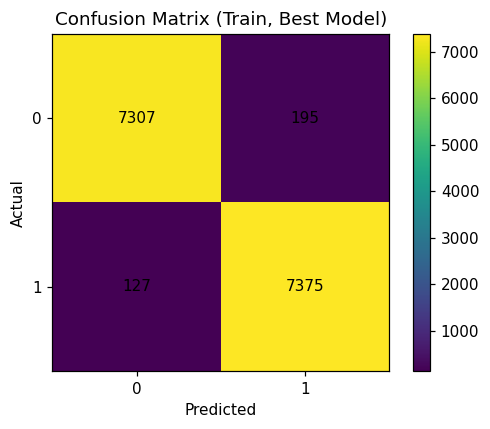

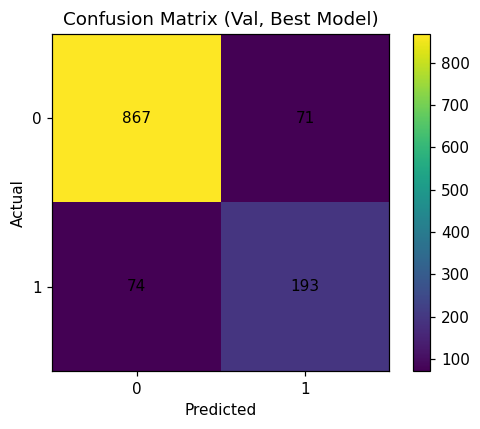

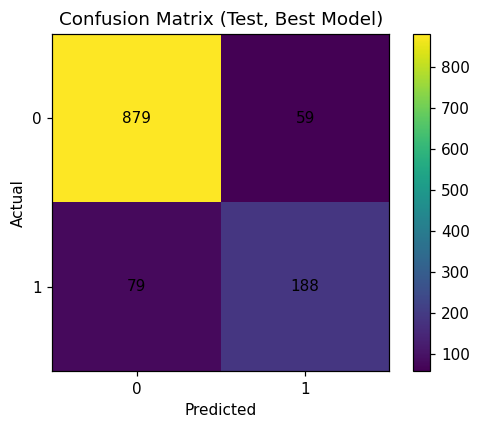

NameError: name 'history' is not defined

In [44]:
# confusion matrix
plot_confusion_matrix(
    ytr_best, ptr_best,
    out_path=os.path.join(OUT_DIR, "confmat_train_best.png"),
    title="Confusion Matrix (Train, Best Model)"
)

plot_confusion_matrix(
    yv_best, pv_best,
    out_path=os.path.join(OUT_DIR, "confmat_val_best.png"),
    title="Confusion Matrix (Val, Best Model)"
)

plot_confusion_matrix(
    yt_best, pt_best,
    out_path=os.path.join(OUT_DIR, "confmat_test_best.png"),
    title="Confusion Matrix (Test, Best Model)"
)

# learning curves
plot_learning_curves(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

plot_accuracy_curve(
    history=history,
    best_epoch=best_epoch,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)

# roc/pr curves
plot_roc_pr(
    y_true=ytr_best,
    y_score=str_best,
    out_dir=OUT_DIR,
    prefix="train_best",
    roc_auc=train_metrics_best["roc_auc"],
    pr_auc=train_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yv_best,
    y_score=sv_best,
    out_dir=OUT_DIR,
    prefix="val_best",
    roc_auc=val_metrics_best["roc_auc"],
    pr_auc=val_metrics_best["pr_auc"]
)

plot_roc_pr(
    y_true=yt_best,
    y_score=st_best,
    out_dir=OUT_DIR,
    prefix="test_best",
    roc_auc=test_metrics_best["roc_auc"],
    pr_auc=test_metrics_best["pr_auc"]
)

plot_split_metrics_bar(
    train_metrics=train_metrics_best,
    val_metrics=val_metrics_best,
    test_metrics=test_metrics_best,
    out_dir=OUT_DIR,
    prefix="convnextv2_tiny_focal"
)


### 18.3 Train/Val/Test Comparison

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
[Info] Saved metrics summary to: ./Baseline+ECA_Output\metrics_summary_base6.csv


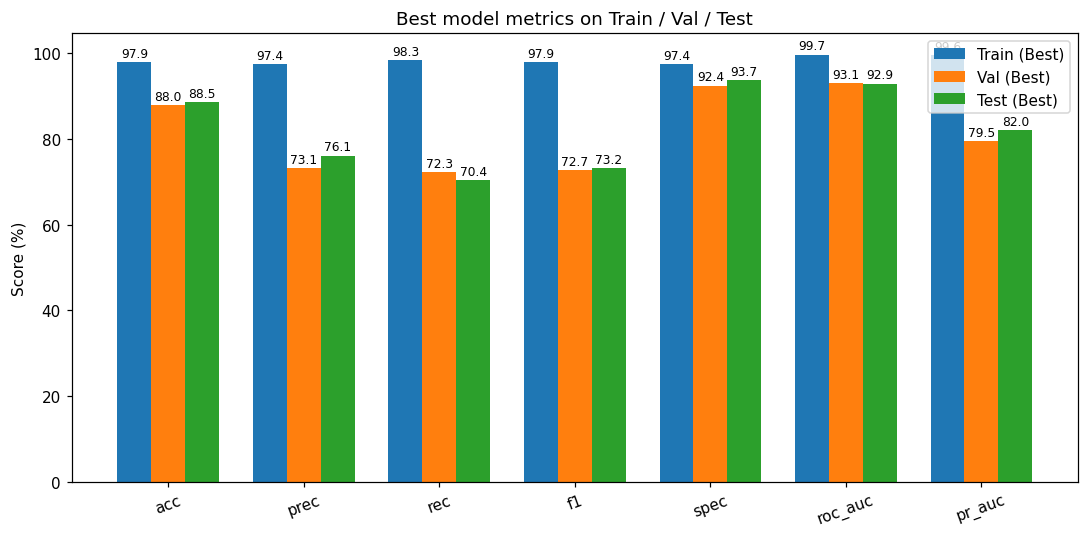

[Info] Saved: ./Baseline+ECA_Output\metrics_bar_train_val_test_best.png


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

rows = [
    {"Split": "Train (Best)", **train_pct},
    {"Split": "Val (Best)",   **val_pct},
    {"Split": "Test (Best)",  **test_pct},
]

metrics_df = pd.DataFrame(rows)

metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))

metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_base6.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

x = np.arange(len(metric_cols)) 
width = 0.25                 

plt.figure(figsize=(10, 5))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - 1) * width  
    bars = plt.bar(x + offset, values, width, label=split)

    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=8)

xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Best model metrics on Train / Val / Test")
plt.legend()
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
print(f"[Info] Saved: {bar_fig_path}")


### 18.4 Seg

In [46]:
def compute_dice_iou(preds: torch.Tensor, targets: torch.Tensor, eps: float = 1e-6):
    preds_f   = preds.view(preds.size(0), -1)
    targets_f = targets.view(targets.size(0), -1)

    inter = (preds_f * targets_f).sum(dim=1)
    union = preds_f.sum(dim=1) + targets_f.sum(dim=1)

    dice = (2.0 * inter + eps) / (union + eps)

    iou_den = (preds_f + targets_f - preds_f * targets_f).sum(dim=1)
    iou = (inter + eps) / (iou_den + eps)

    return dice, iou


def denormalize(img_tensor: torch.Tensor):
    img = img_tensor.detach().cpu().clone()
    img = img * 0.25 + 0.5   # x * std + mean
    img = img.clamp(0.0, 1.0)
    return img.squeeze(0).numpy()

@torch.no_grad()
def visualize_segmentation_examples(
    model,
    loader,
    device,
    threshold: float = 0.5,
    num_pos: int = 2,
    num_neg: int = 2,
    num_hard: int = 2,
    save_dir: str = None,
    prefix: str = "seg_example",
):

    model.eval()
    pos_shown = neg_shown = hard_shown = 0
    example_idx = 0 

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    for xb, yb, mb in loader:
        xb = xb.to(device, non_blocking=True)
        yb = yb.to(device, non_blocking=True)
        mb = mb.to(device, non_blocking=True)

        out = model(xb)
        if isinstance(out, tuple):
            _, seg_logits = out  # (cls_logits, seg_logits)
        else:
            raise ValueError("Model output must be (cls_logits, seg_logits)")

        # [B,1,H,W]
        probs = torch.sigmoid(seg_logits)
        preds = (probs >= threshold).float()

        dice_batch, iou_batch = compute_dice_iou(preds, mb)

        for i in range(xb.size(0)):
            dice_val = float(dice_batch[i].cpu().item())
            iou_val  = float(iou_batch[i].cpu().item())
            label    = int(yb[i].cpu().item())

            category = None
            title_suffix = ""

            if label == 1 and dice_val >= 0.8 and pos_shown < num_pos:
                category = "pos"
                title_suffix = f"Positive, easy (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 0 and dice_val >= 0.95 and neg_shown < num_neg:
                category = "neg"
                title_suffix = f"Negative (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            elif label == 1 and 0.3 <= dice_val <= 0.7 and hard_shown < num_hard:
                category = "hard"
                title_suffix = f"Positive, hard (Dice={dice_val:.2f}, IoU={iou_val:.2f})"

            if category is None:
                continue

            img_np  = denormalize(xb[i])                # [H,W]
            gt_mask = mb[i].detach().cpu().numpy().squeeze()   # [H,W]
            pr_mask = preds[i].detach().cpu().numpy().squeeze() # [H,W]

            fig, axes = plt.subplots(1, 3, figsize=(12, 4))

            axes[0].imshow(img_np, cmap="gray")
            axes[0].set_title(f"Image (label={label})")
            axes[0].axis("off")

            axes[1].imshow(img_np, cmap="gray")
            axes[1].imshow(gt_mask, cmap="jet", alpha=0.4)
            axes[1].set_title("Ground Truth mask (overlay)")
            axes[1].axis("off")

            axes[2].imshow(img_np, cmap="gray")
            axes[2].imshow(pr_mask, cmap="jet", alpha=0.4)
            axes[2].set_title(f"Predicted mask\nDice={dice_val:.2f}, IoU={iou_val:.2f}")
            axes[2].axis("off")

            plt.suptitle(title_suffix)
            plt.tight_layout()

            if save_dir is not None:
                fname = f"{prefix}_{category}_{example_idx}.png"
                fig.savefig(os.path.join(save_dir, fname), dpi=300)

            plt.show()
            example_idx += 1

            if category == "pos":
                pos_shown += 1
            elif category == "neg":
                neg_shown += 1
            elif category == "hard":
                hard_shown += 1

            if pos_shown >= num_pos and neg_shown >= num_neg and hard_shown >= num_hard:
                return

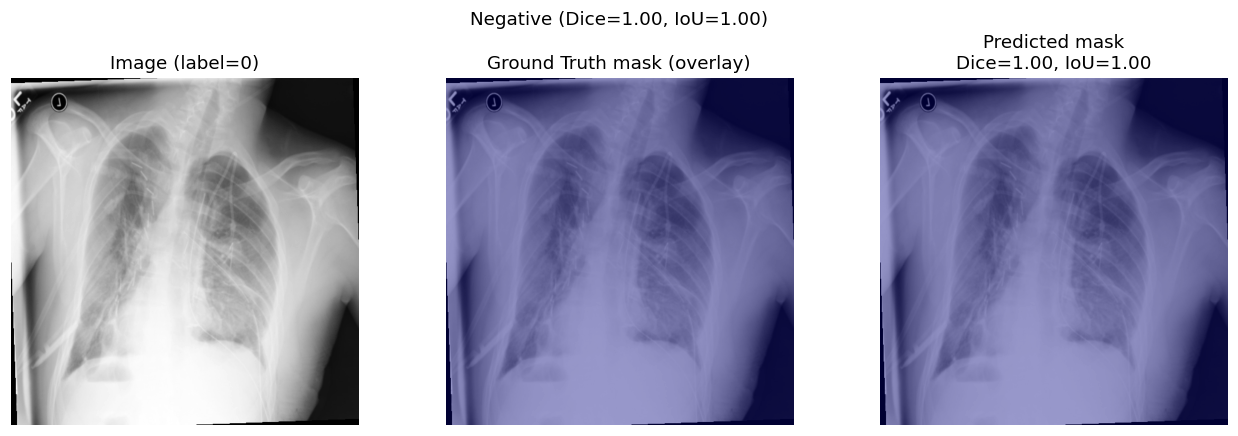

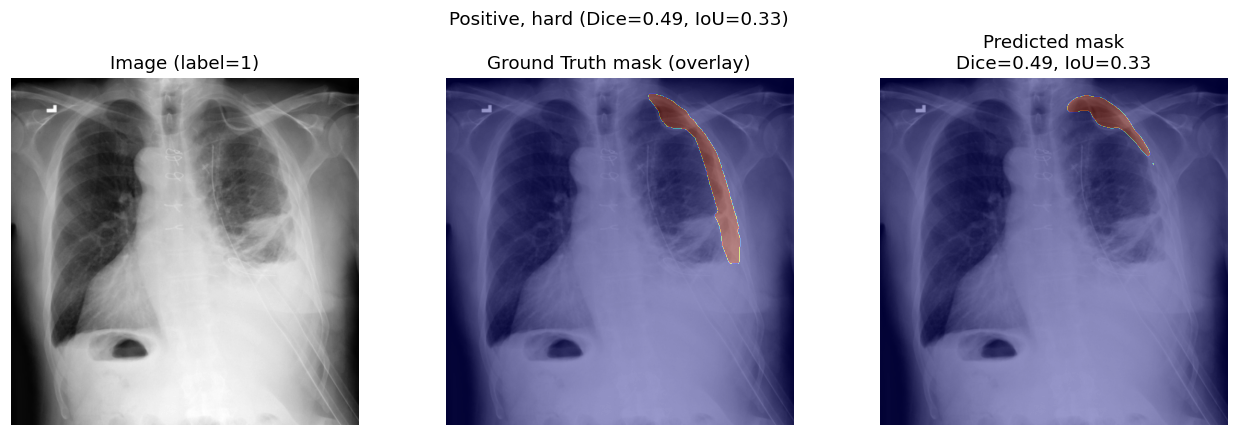

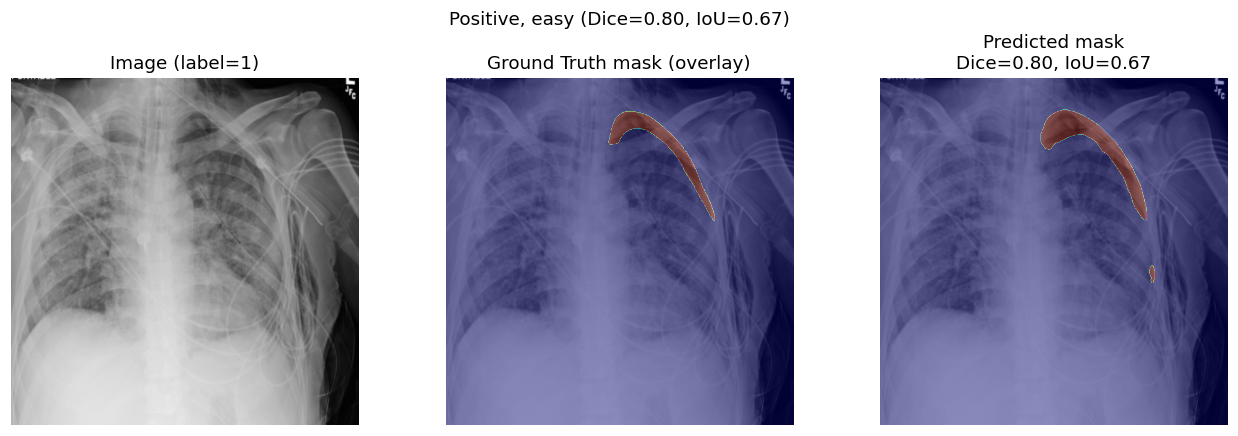

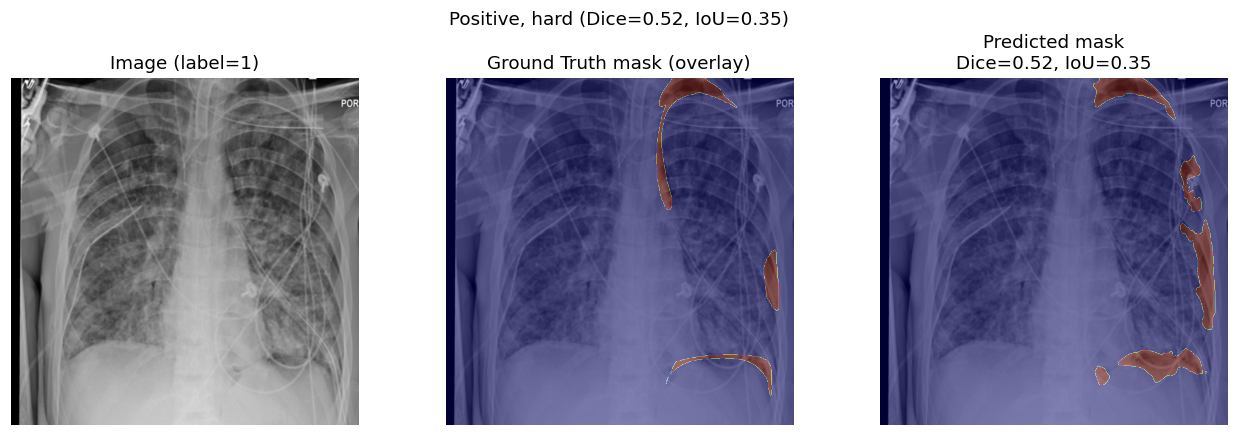

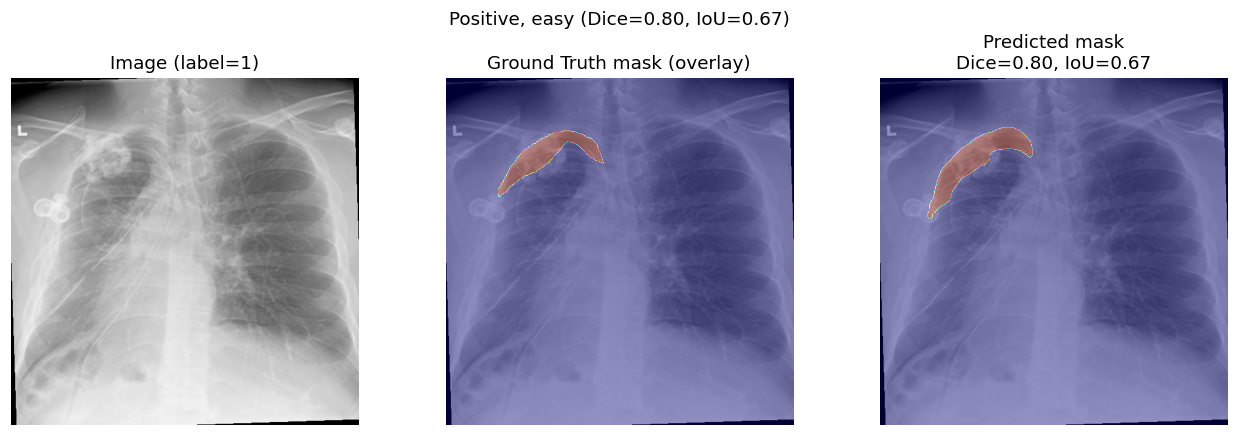

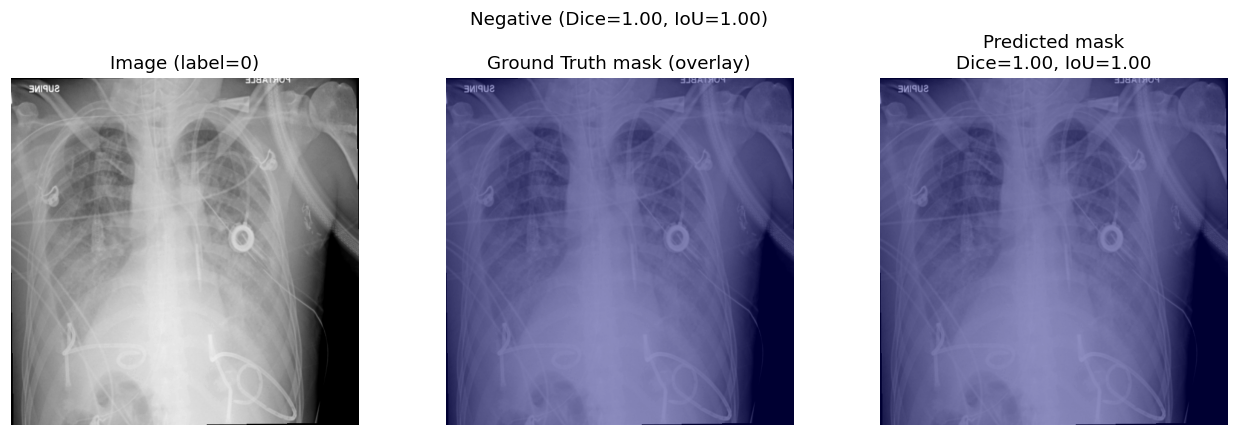

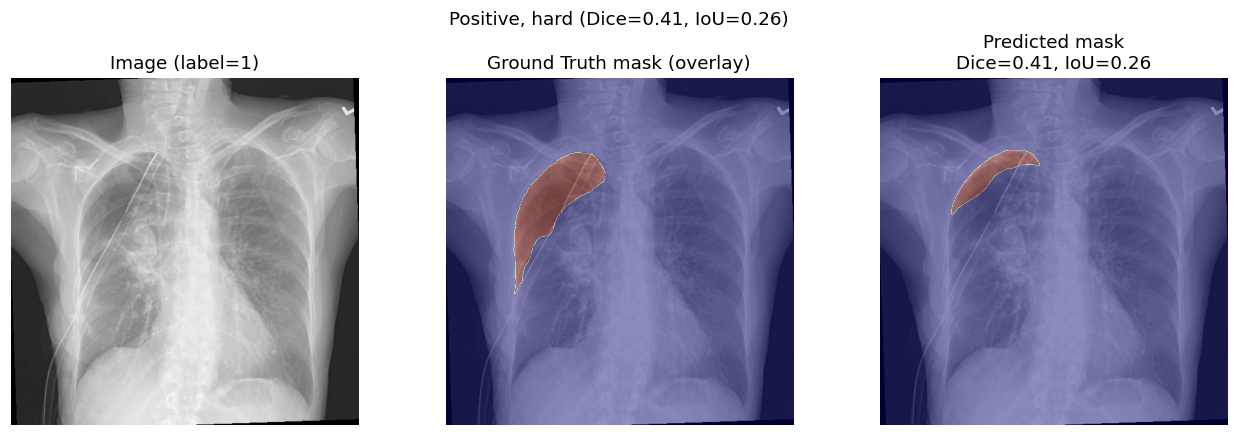

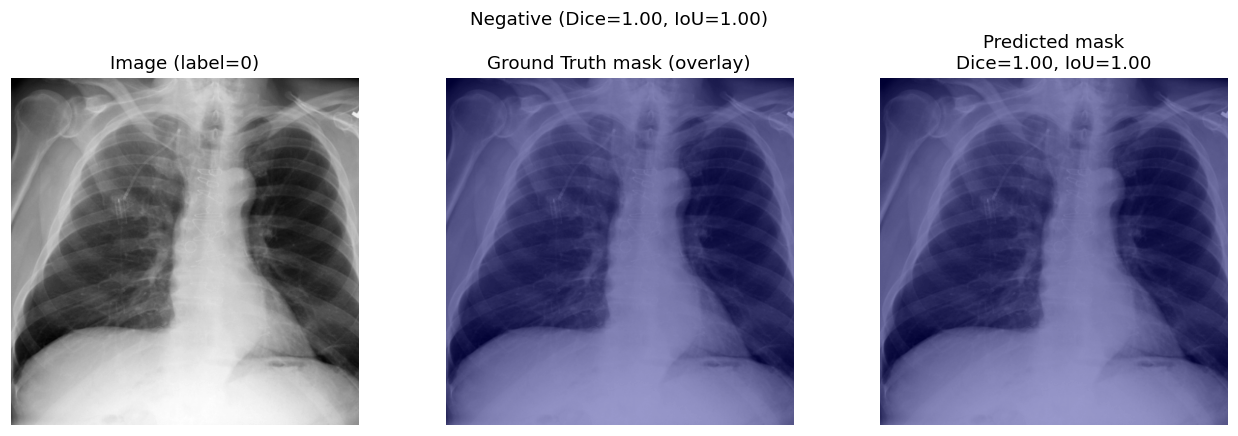

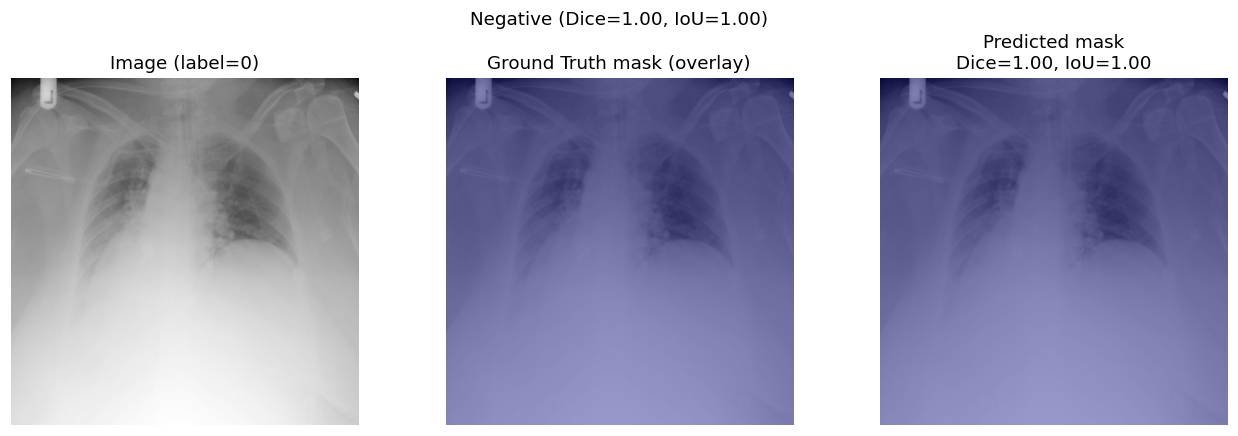

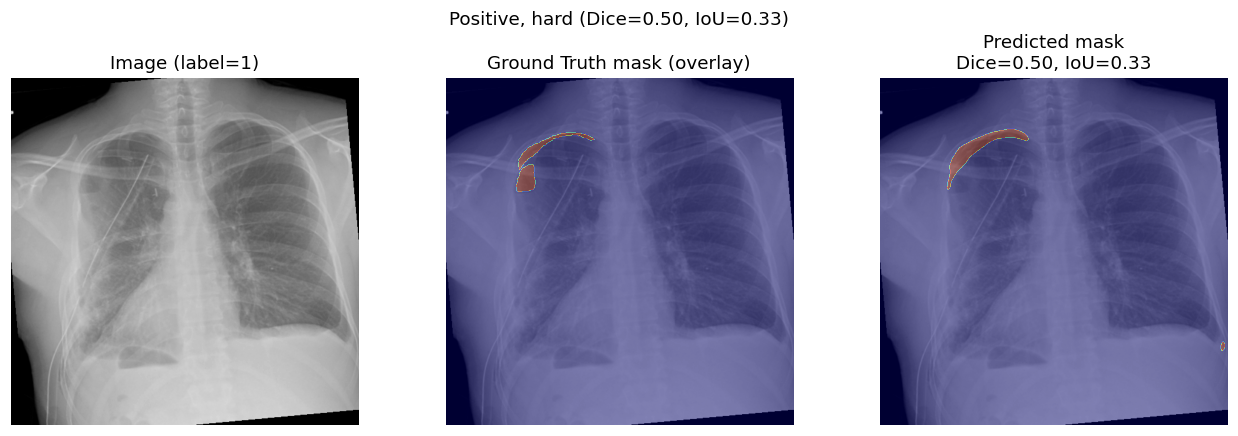

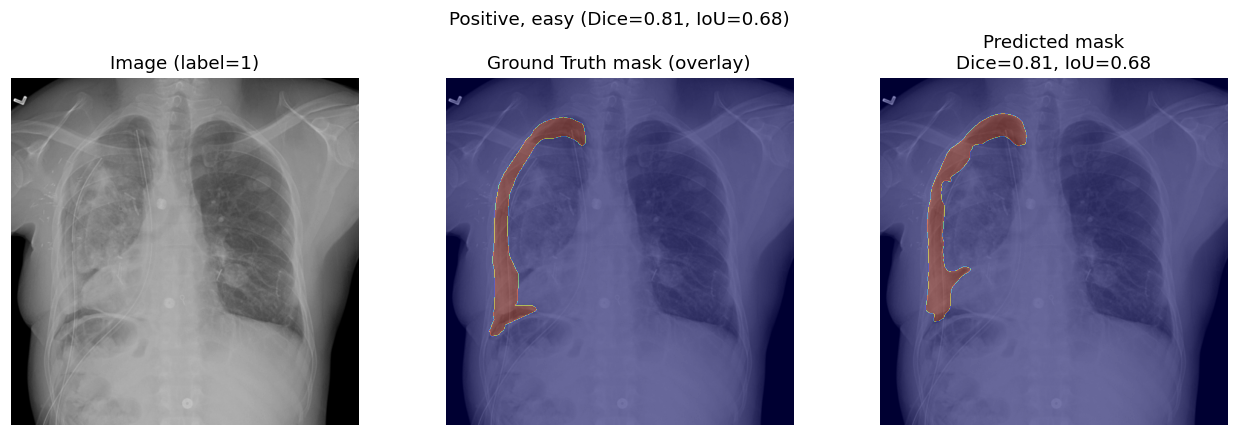

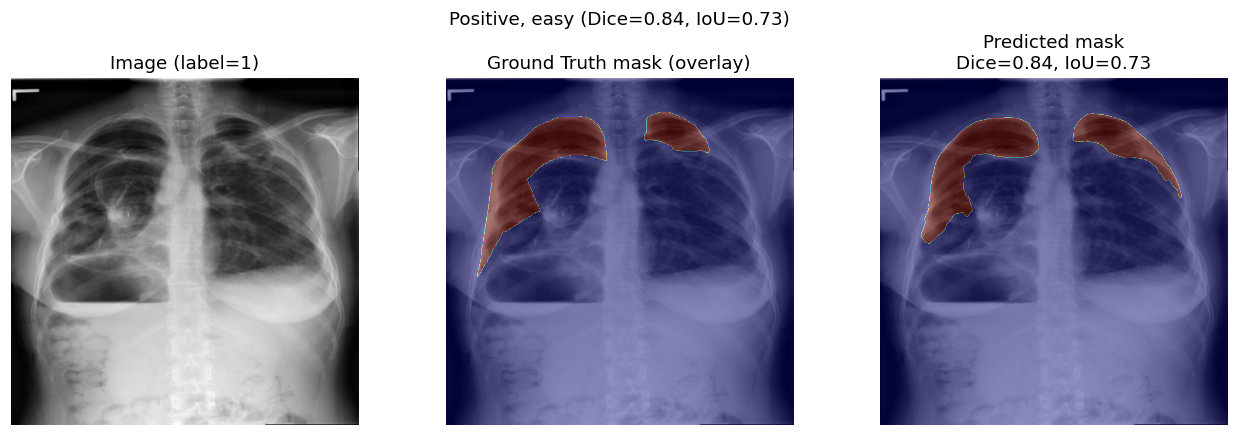

In [47]:
visualize_segmentation_examples(
    model=model,        
    loader=dl_train,    
    device=device,
    threshold=0.5,   
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR, 
    prefix="seg_train_examples"
)

eval_mask_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_test_seg = PandasImageMaskDataset(test_df, mask_root=MASK_ROOT, joint_transform=eval_mask_tfms)
dl_test_seg = DataLoader(ds_test_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

visualize_segmentation_examples(
    model=model,
    loader=dl_test_seg,
    device=device,
    threshold=0.5,
    num_pos=2,
    num_neg=2,
    num_hard=2,
    save_dir=OUT_DIR,
    prefix="seg_test_examples"
)


### 18.5 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Test):   0%|          | 0/302 [00:00<?, ?it/s]

[Seg @ Test, positive masks only]
Dice: mean=0.4849, median=0.5185
IoU : mean=0.3553, median=0.3500
Num positive masks: 266


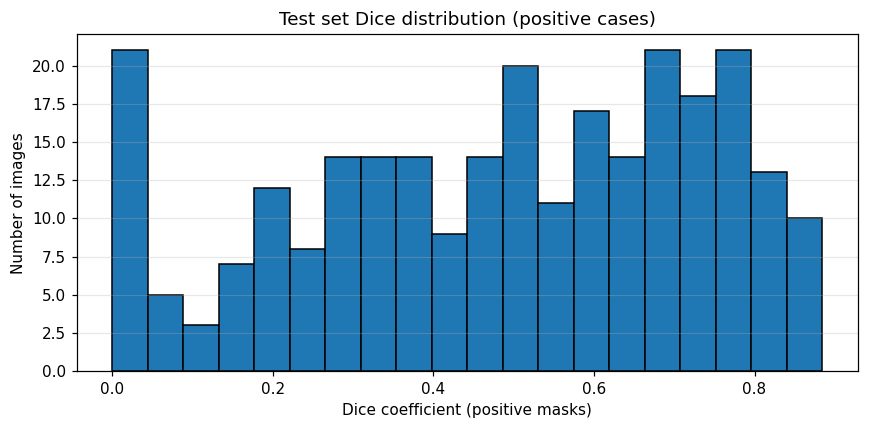

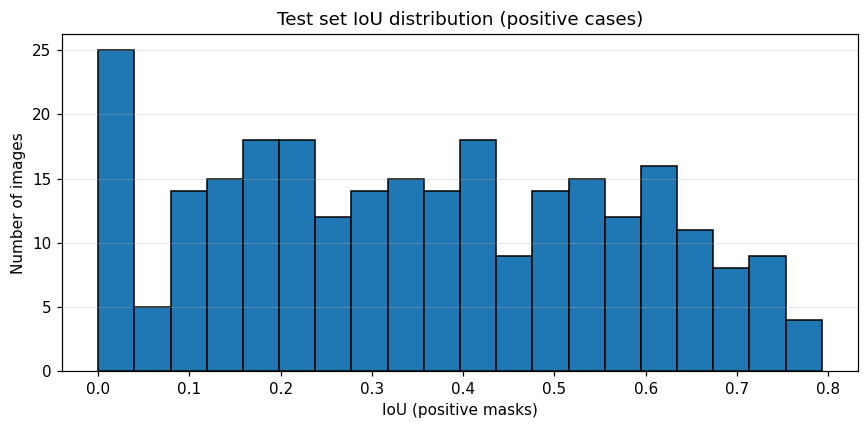

In [ ]:
from tqdm.auto import tqdm
model.eval()

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_test_seg, desc="Seg Eval (Test)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Test, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "test_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "test_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Test set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "test_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.6 Segmentation metrics on Test set (Dice / IoU + hist) test

Seg Eval (Train):   0%|          | 0/2669 [00:00<?, ?it/s]

[Seg @ Train, positive masks only]
Dice: mean=0.5928, median=0.6523
IoU : mean=0.4582, median=0.4840
Num positive masks: 2375


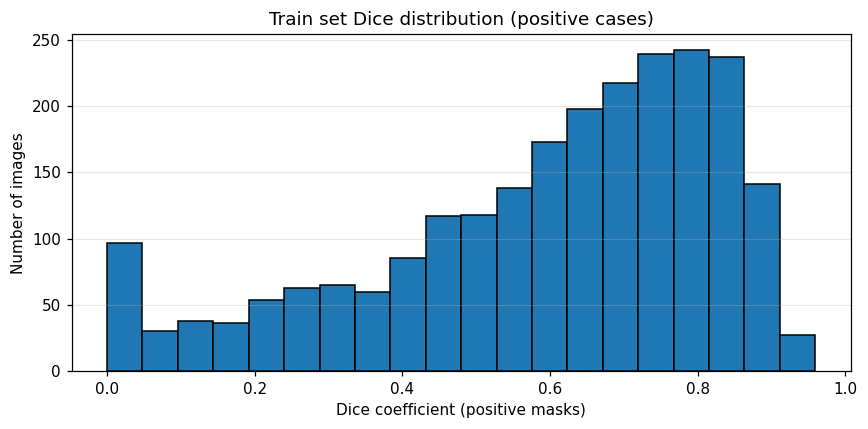

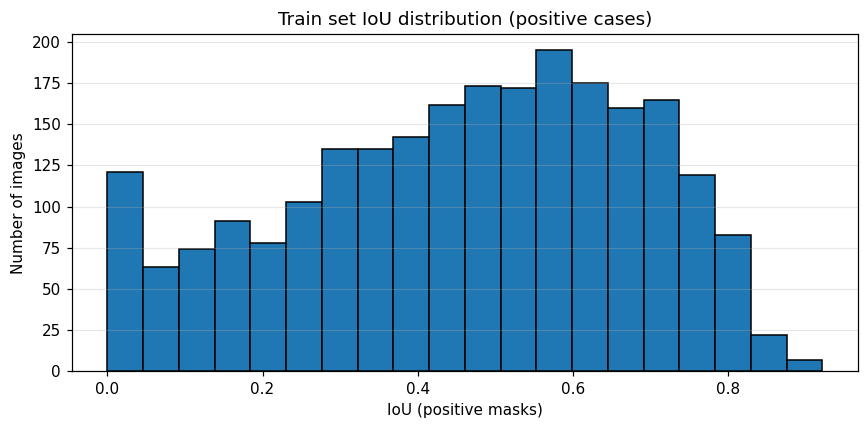

In [62]:
from tqdm.auto import tqdm
model.eval()

eval_train_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_train_seg = PandasImageMaskDataset(train_df, mask_root=MASK_ROOT, joint_transform=eval_train_tfms)
dl_train_seg = DataLoader(ds_train_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_train_seg, desc="Seg Eval (Train)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Train, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "train_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "train_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Train set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "train_seg_iou_hist_pos.png"), dpi=300)
plt.show()


### 18.7 Segmentation metrics on Test set (Dice / IoU + hist) val

Seg Eval (Val):   0%|          | 0/302 [00:00<?, ?it/s]

[Seg @ Val, positive masks only]
Dice: mean=0.4595, median=0.4940
IoU : mean=0.3402, median=0.3280
Num positive masks: 267


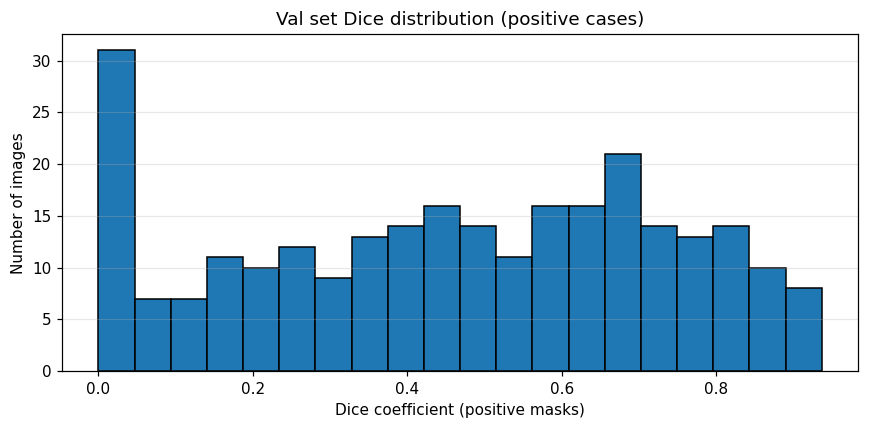

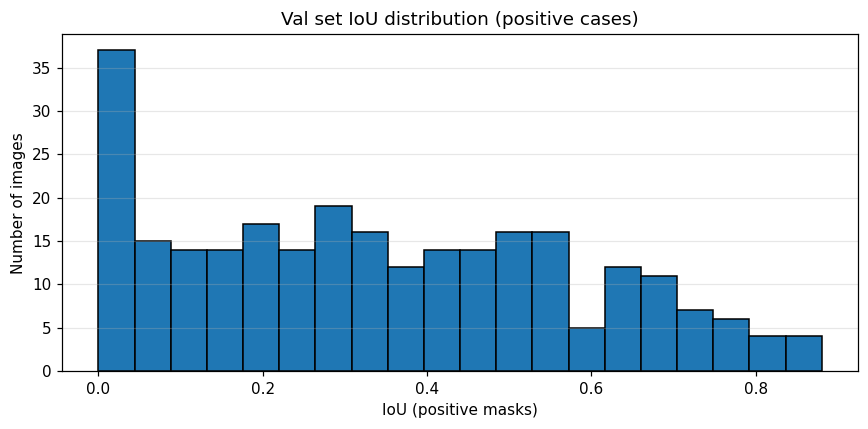

In [63]:
from tqdm.auto import tqdm
model.eval()

eval_val_tfms = JointImageMaskTransform(out_size=IMG_SIZE)

ds_val_seg = PandasImageMaskDataset(val_df, mask_root=MASK_ROOT, joint_transform=eval_val_tfms)
dl_val_seg = DataLoader(ds_val_seg, batch_size=BATCH, shuffle=False, num_workers=0, pin_memory=True)

all_dice_pos = []
all_iou_pos  = []

with torch.no_grad():
    for xb, yb, mb in tqdm(dl_val_seg, desc="Seg Eval (Val)"):
        xb = xb.to(device)          
        mb = mb.to(device)          # GT mask, [B,1,H,W], 0/1

        cls_logits, seg_logits = model(xb)   # seg_logits: [B,1,H,W]

        seg_probs = torch.sigmoid(seg_logits)
        seg_pred  = (seg_probs > 0.5).float()

        dice_batch, iou_batch = compute_dice_iou(seg_pred, mb) 
        pos_mask = (mb.view(mb.size(0), -1).sum(dim=1) > 0)

        if pos_mask.any():
            all_dice_pos.extend(dice_batch[pos_mask].cpu().numpy().tolist())
            all_iou_pos.extend(iou_batch[pos_mask].cpu().numpy().tolist())

all_dice_pos = np.array(all_dice_pos)
all_iou_pos  = np.array(all_iou_pos)

print(f"[Seg @ Val, positive masks only]")
print(f"Dice: mean={all_dice_pos.mean():.4f}, median={np.median(all_dice_pos):.4f}")
print(f"IoU : mean={all_iou_pos .mean():.4f}, median={np.median(all_iou_pos ):.4f}")
print(f"Num positive masks: {len(all_dice_pos)}")

# np.save(os.path.join(OUT_DIR, "val_seg_dice_pos.npy"), all_dice_pos)
# np.save(os.path.join(OUT_DIR, "val_seg_iou_pos.npy"),  all_iou_pos)

plt.figure(figsize=(8, 4))
plt.hist(all_dice_pos, bins=20, edgecolor="black")
plt.xlabel("Dice coefficient (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set Dice distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_dice_hist_pos.png"), dpi=300)
plt.show()

plt.figure(figsize=(8, 4))
plt.hist(all_iou_pos, bins=20, edgecolor="black")
plt.xlabel("IoU (positive masks)")
plt.ylabel("Number of images")
plt.title("Val set IoU distribution (positive cases)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
# plt.savefig(os.path.join(OUT_DIR, "val_seg_iou_hist_pos.png"), dpi=300)
plt.show()


## 19. Threshold tunning

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, average_precision_score
)

def sweep_thresholds(y_true, y_score, thresholds=None, sort_by="f1", verbose=True):
    y_true = np.asarray(y_true).astype(int).ravel()
    y_score = np.asarray(y_score).ravel()

    if thresholds is None:
        thresholds = np.linspace(0.01, 0.95, 19)

    results = []
    for t in thresholds:
        y_pred = (y_score >= t).astype(int)

        acc  = accuracy_score(y_true, y_pred)
        prec = precision_score(y_true, y_pred, zero_division=0)
        rec  = recall_score(y_true, y_pred, zero_division=0)
        f1   = f1_score(y_true, y_pred, zero_division=0)

        cm = confusion_matrix(y_true, y_pred)
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
            spec = tn / (tn + fp + 1e-8)
        else:
            spec = float("nan")

        results.append({
            "threshold": t,
            "acc": acc,
            "prec": prec,
            "rec": rec,
            "f1": f1,
            "spec": spec,
        })

    df_thr = pd.DataFrame(results)
    df_thr_sorted = df_thr.sort_values(sort_by, ascending=False).reset_index(drop=True)

    if verbose:
        print(f"\n=== Top 10 thresholds on val (sorted by {sort_by}) ===")
        tmp = df_thr_sorted.copy()
        for col in ["acc", "prec", "rec", "f1", "spec"]:
            tmp[col] = tmp[col] * 100.0
        print(tmp.head(10).to_string(
            index=False, 
            formatters={
                "threshold": "{:.3f}".format,
                "acc": "{:.3f}".format,
                "prec": "{:.3f}".format,
                "rec": "{:.3f}".format,
                "f1": "{:.3f}".format,
                "spec": "{:.3f}".format
            }
        ))

        best_row = df_thr_sorted.iloc[0]
        print("\nBest threshold on validation set (by {}):".format(sort_by))
        print(
            f"t = {best_row['threshold']:.3f}, "
            f"Acc={best_row['acc']*100:.3f}%, "
            f"Prec={best_row['prec']*100:.3f}%, "
            f"Rec={best_row['rec']*100:.3f}%, "
            f"F1={best_row['f1']*100:.3f}%, "
            f"Spec={best_row['spec']*100:.3f}%"
        )

    return df_thr_sorted


In [49]:
def plot_threshold_metrics(df_thr, out_dir, prefix="val_thr"):
    os.makedirs(out_dir, exist_ok=True)

    thr = df_thr["threshold"].values

    plt.figure(figsize=(6,4))
    for key, label in [
        ("acc",  "Acc"),
        ("f1",   "F1"),
        ("rec",  "Recall"),
        ("spec", "Specificity"),
    ]:
        if key in df_thr.columns:
            plt.plot(thr, df_thr[key].values * 100.0, marker="o", label=label)

    plt.xlabel("Threshold")
    plt.ylabel("Metric (%)")
    plt.title("Metrics vs Threshold (Validation)")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, f"{prefix}_metrics_vs_threshold.png"), dpi=300)
    plt.show()

### 19.1 Find best threshold


=== Top 10 thresholds on val (sorted by f1) ===
threshold    acc   prec    rec     f1   spec
    0.376 87.137 67.391 81.273 73.684 88.806
    0.428 87.220 68.647 77.903 72.982 89.872
    0.480 87.801 71.898 73.783 72.828 91.791
    0.532 88.050 74.699 69.663 72.093 93.284
    0.323 85.726 63.610 83.146 72.078 86.461
    0.271 84.813 60.995 87.266 71.803 84.115
    0.584 88.216 77.293 66.292 71.371 94.456
    0.637 88.465 81.683 61.798 70.362 96.055
    0.219 82.656 56.744 91.386 70.014 80.171
    0.689 88.133 84.831 56.554 67.865 97.122

Best threshold on validation set (by f1):
t = 0.376, Acc=87.137%, Prec=67.391%, Rec=81.273%, F1=73.684%, Spec=88.806%


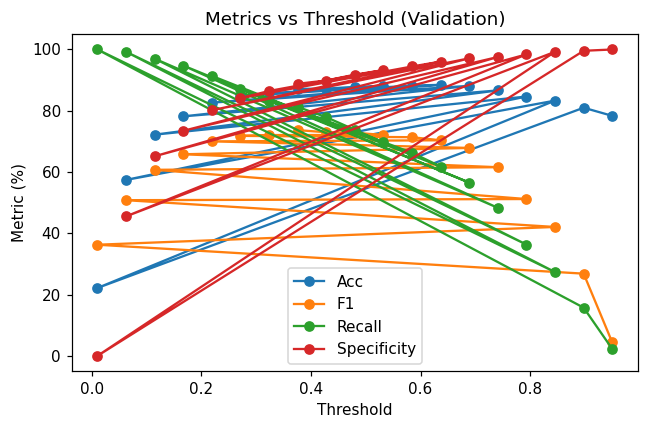


>>> The best threshold on validation set: best_t = 0.376
[Info] Saved best threshold to: ./Baseline+ECA_Output\best_threshold.txt


In [ ]:
df_thr_val = sweep_thresholds(yv_best, sv_best, sort_by="f1", verbose=True)
plot_threshold_metrics(df_thr_val, OUT_DIR, prefix="val_thr")

best_t = df_thr_val.iloc[0]["threshold"]
print(f"\n>>> The best threshold on validation set: best_t = {best_t:.3f}")

thr_path = os.path.join(OUT_DIR, "best_th" \
"reshold.txt")
with open(thr_path, "w") as f:
    f.write(f"{best_t:.6f}\n")
print(f"[Info] Saved best threshold to: {thr_path}")


### 19.2 Re-evaluate using best threshold


[Best threshold model @ Test (t=0.376)]
Accuracy (%)        : 88.050
Precision (%)       : 70.033
Recall (%)          : 80.524
F1-Score (%)        : 74.913
Specificity (%)     : 90.192
ROC-AUC (%)         : 92.897
Precision-recall (%): 82.036

[Best threshold model @ Val (t=0.376)]
Accuracy (%)        : 87.137
Precision (%)       : 67.391
Recall (%)          : 81.273
F1-Score (%)        : 73.684
Specificity (%)     : 88.806
ROC-AUC (%)         : 93.115
Precision-recall (%): 79.543


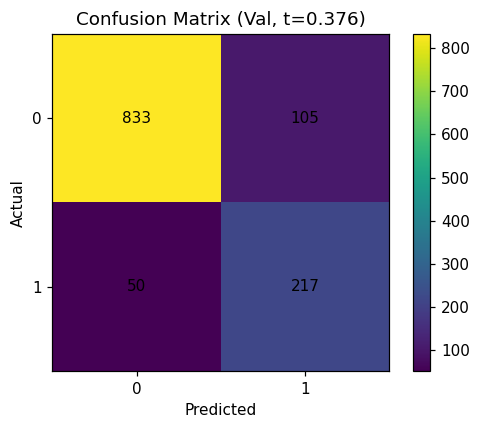

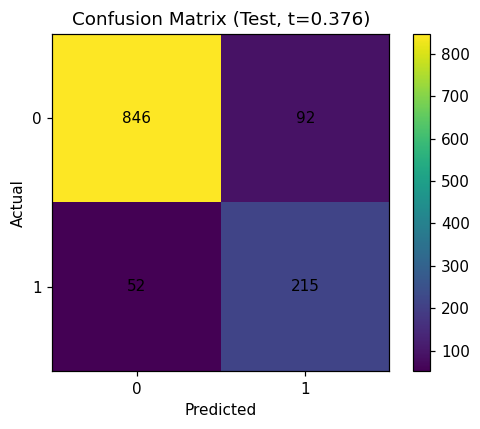

In [53]:
yt = np.asarray(yt_best).astype(int).ravel()
st = np.asarray(st_best).ravel()

y_test_pred = (st >= best_t).astype(int)

test_acc  = accuracy_score(yt, y_test_pred)
test_prec = precision_score(yt, y_test_pred, zero_division=0)
test_rec  = recall_score(yt, y_test_pred, zero_division=0)
test_f1   = f1_score(yt, y_test_pred, zero_division=0)

cm_test = confusion_matrix(yt, y_test_pred)
if cm_test.shape == (2, 2):
    tn, fp, fn, tp = cm_test.ravel()
    test_spec = tn / (tn + fp + 1e-8)
else:
    test_spec = float("nan")

test_roc = roc_auc_score(yt, st)
test_pr  = average_precision_score(yt, st)

print(f"\n[Best threshold model @ Test (t={best_t:.3f})]")
print(f"Accuracy (%)        : {test_acc*100:.3f}")
print(f"Precision (%)       : {test_prec*100:.3f}")
print(f"Recall (%)          : {test_rec*100:.3f}")
print(f"F1-Score (%)        : {test_f1*100:.3f}")
print(f"Specificity (%)     : {test_spec*100:.3f}")
print(f"ROC-AUC (%)         : {test_roc*100:.3f}")
print(f"Precision-recall (%): {test_pr*100:.3f}")

y_val_pred = (np.asarray(sv_best) >= best_t).astype(int)
val_acc2  = accuracy_score(yv_best, y_val_pred)
val_prec2 = precision_score(yv_best, y_val_pred, zero_division=0)
val_rec2  = recall_score(yv_best, y_val_pred, zero_division=0)
val_f12   = f1_score(yv_best, y_val_pred, zero_division=0)

cm_val = confusion_matrix(yv_best, y_val_pred)
if cm_val.shape == (2, 2):
    tn, fp, fn, tp = cm_val.ravel()
    val_spec2 = tn / (tn + fp + 1e-8)
else:
    val_spec2 = float("nan")

val_roc2 = roc_auc_score(yv_best, sv_best)
val_pr2  = average_precision_score(yv_best, sv_best)

print(f"\n[Best threshold model @ Val (t={best_t:.3f})]")
print(f"Accuracy (%)        : {val_acc2*100:.3f}")
print(f"Precision (%)       : {val_prec2*100:.3f}")
print(f"Recall (%)          : {val_rec2*100:.3f}")
print(f"F1-Score (%)        : {val_f12*100:.3f}")
print(f"Specificity (%)     : {val_spec2*100:.3f}")
print(f"ROC-AUC (%)         : {val_roc2*100:.3f}")
print(f"Precision-recall (%): {val_pr2*100:.3f}")

plot_confusion_matrix(
    y_true=yv_best,
    y_pred=y_val_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_val_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Val, t={best_t:.3f})"
)

plot_confusion_matrix(
    y_true=yt,
    y_pred=y_test_pred,
    out_path=os.path.join(OUT_DIR, f"confmat_test_best_t_{best_t:.3f}.png"),
    title=f"Confusion Matrix (Test, t={best_t:.3f})"
)

### 19.3 Train/Val/Test Comparison after threshold tunning

[Debug] metrics_df columns: ['Split', 'acc', 'prec', 'rec', 'f1', 'spec', 'roc_auc', 'pr_auc']
                  Split     acc    prec     rec      f1    spec  roc_auc  \
0     Train (Best @0.5)  97.854  97.424  98.307  97.864  97.401   99.674   
1     Val   (Best @0.5)  87.967  73.106  72.285  72.693  92.431   93.115   
2     Test  (Best @0.5)  88.548  76.113  70.412  73.152  93.710   92.897   
3  Val   (Best_t=0.376)  87.137  67.391  81.273  73.684  88.806   93.115   
4  Test  (Best_t=0.376)  88.050  70.033  80.524  74.913  90.192   92.897   

   pr_auc  
0  99.593  
1  79.543  
2  82.036  
3  79.543  
4  82.036  
[Info] Saved metrics summary to: ./Baseline+ECA_Output\metrics_summary_with_bestt.csv


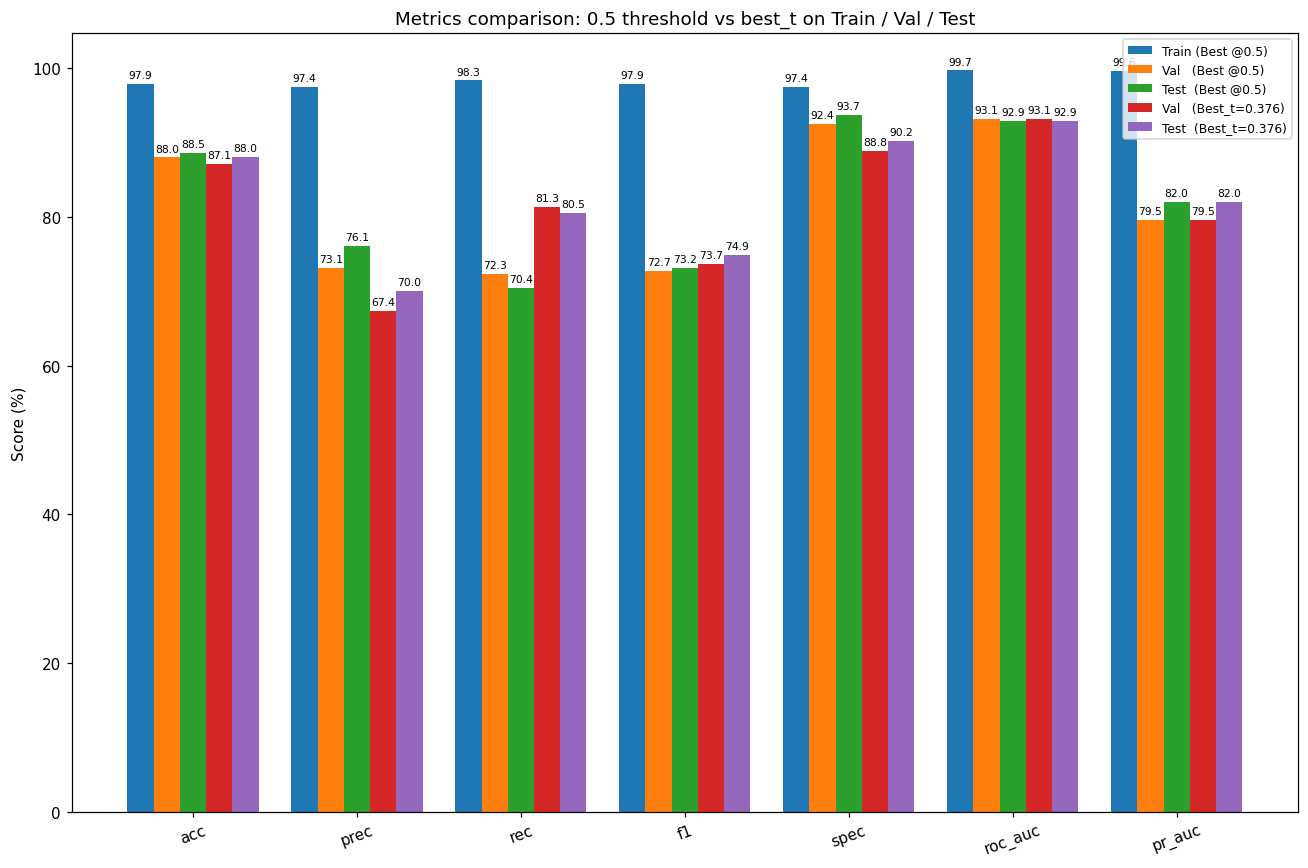

In [59]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

val_pct_best_t = {
    "acc":     round(val_acc2  * 100, 3),
    "prec":    round(val_prec2 * 100, 3),
    "rec":     round(val_rec2  * 100, 3),
    "f1":      round(val_f12   * 100, 3),
    "spec":    round(val_spec2 * 100, 3),
    "roc_auc": round(val_roc2  * 100, 3),
    "pr_auc":  round(val_pr2   * 100, 3),
}

test_pct_best_t = {
    "acc":     round(test_acc  * 100, 3),
    "prec":    round(test_prec * 100, 3),
    "rec":     round(test_rec  * 100, 3),
    "f1":      round(test_f1   * 100, 3),
    "spec":    round(test_spec * 100, 3),
    "roc_auc": round(test_roc  * 100, 3),
    "pr_auc":  round(test_pr   * 100, 3),
}

rows = [
    {"Split": "Train (Best @0.5)", **train_pct},
    {"Split": "Val   (Best @0.5)", **val_pct},
    {"Split": "Test  (Best @0.5)", **test_pct},
    {"Split": f"Val   (Best_t={best_t:.3f})",  **val_pct_best_t},
    {"Split": f"Test  (Best_t={best_t:.3f})", **test_pct_best_t},
]

metrics_df = pd.DataFrame(rows)

metric_cols = [c for c in metrics_df.columns if c != "Split"]
metrics_df = metrics_df[["Split"] + metric_cols]

print("[Debug] metrics_df columns:", list(metrics_df.columns))
print(metrics_df)

metrics_csv_path = os.path.join(OUT_DIR, "metrics_summary_with_bestt.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"[Info] Saved metrics summary to: {metrics_csv_path}")

x = np.arange(len(metric_cols))     
n_splits = len(metrics_df)          
width = 0.8 / n_splits                

plt.figure(figsize=(12, 8))

for i, split in enumerate(metrics_df["Split"]):
    values = metrics_df.loc[i, metric_cols].values.astype(float)
    offset = (i - (n_splits - 1) / 2) * width
    bars = plt.bar(x + offset, values, width, label=split)

    for xi, v in zip(x + offset, values):
        plt.text(xi, v + 0.5, f"{v:.1f}",
                 ha="center", va="bottom", fontsize=7)

xtick_labels = [
    c.replace("(%)", "").replace("%", "").strip()
    for c in metric_cols
]

plt.xticks(x, xtick_labels, rotation=20)
plt.ylabel("Score (%)")
plt.title("Metrics comparison: 0.5 threshold vs best_t on Train / Val / Test")
plt.legend(fontsize=8)
plt.tight_layout()

bar_fig_path = os.path.join(OUT_DIR, "metrics_bar_train_val_test_best_vs_bestt.png")
plt.savefig(bar_fig_path, dpi=300)
plt.show()
